# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_MM_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_MM_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_MM_2ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_MM_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_MM_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_MM_2ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.312950        0.200245  0.048534  0.259149  0.059318   
       1.0    0.317689        0.197780  0.045460  0.191632  0.104224   
       1.5    0.319685        0.193850  0.042234  0.133763  0.118471   
       2.0    0.320377        0.189189  0.039390  0.092967  0.109573   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.195011  0.006108  0.038680  0.058472  0.001079  
       1.0   0.201154  0.007591  0.033170  0.073280  0.003737  
       1.5   0.217767  0.010131  0.025864  0.093370  0.007880  
       2.0   0.228526  0.013479  0.019942  0.116984  0.013686

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.312950        0.200245  0.048534  0.259149  0.059318   
       1.0    0.317689        0.197780  0.045460  0.191632  0.104224   
       1.5    0.319685        0.193850  0.042234  0.133763  0.118471   
       2.0    0.320377        0.189189  0.039390  0.092967  0.109573   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.195011  0.006108  0.038680  0.058472  0.001079  
       1.0   0.201154  0.007591  0.033170  0.073280  0.003737  
       1.5   0.217767  0.010131  0.025864  0.093370  0.007880  
       2.0   0.228526  0.013479  0.019942  0.116984  0.013686

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.312950        0.200245  0.048534  0.259149  0.059318   
       1.0    0.317689        0.197780  0.045460  0.191632  0.104224   
       1.5    0.319685        0.193850  0.042234  0.133763  0.118471   
       2.0    0.320377        0.189189  0.039390  0.092967  0.109573   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.195011  0.006108  0.038680  0.058472  0.001079  
       1.0   0.201154  0.007591  0.033170  0.073280  0.003737  
       1.5   0.217767  0.010131  0.025864  0.093370  0.007880  
       2.0   0.228526  0.013479  0.019942  0.116984  0.013686

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.295498        0.200425  0.060938  0.195920  0.112245   
         1.0    0.272992        0.193767  0.078634  0.079861  0.171375   
         1.5    0.247259        0.183511  0.094572  0.031327  0.148031   
         2.0    0.222240        0.171758  0.106426  0.018138  0.106571   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         0.5   0.181601  0.014419  0.038643  0.064898  0.000488  
         1.0   0.173169  0.020703  0.032371  0.100826  0.001928  
         1.5   0.154712  0.027644  0.028134  0.149235  0.004613  
         2.0   0.109090  0.029339  0.027014  0.204377  0.008835

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  546287.047997  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         0.5      286614.273964  
         1.0      398139.231561  
         1.5      457478.291179  
         2.0      494315.467226

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


,,Missing Values,% of Total Values


,,Missing Values,% of Total Values


# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


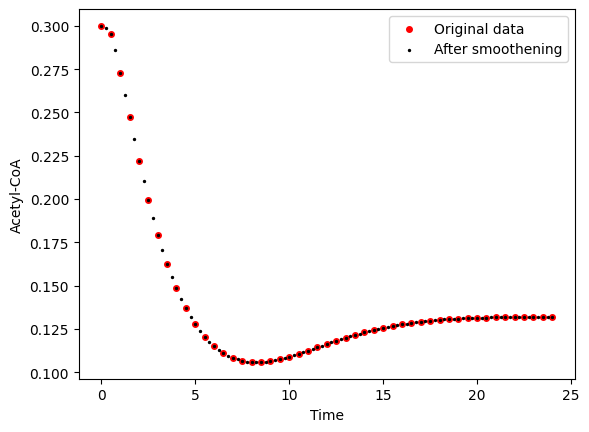

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


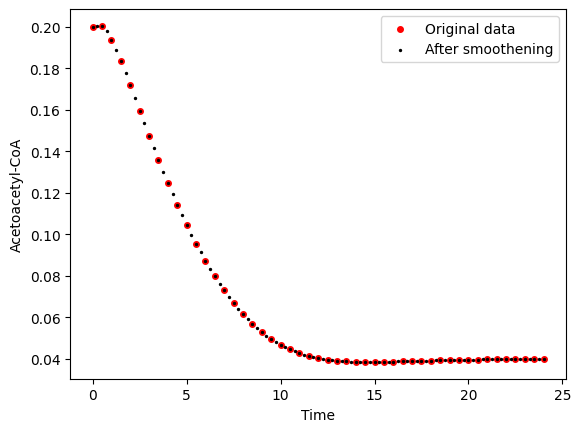

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


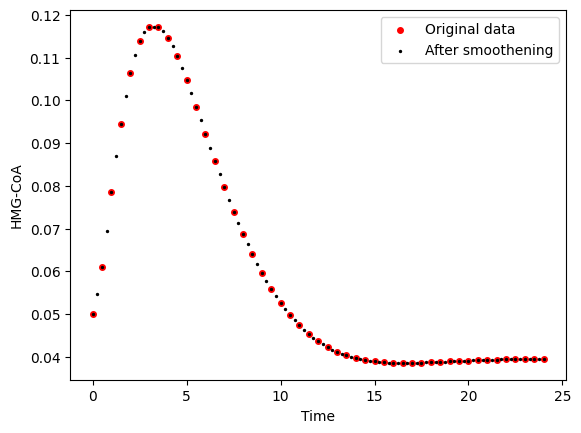

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


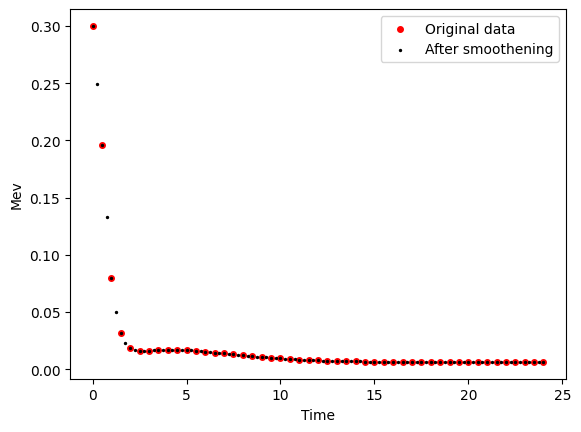

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


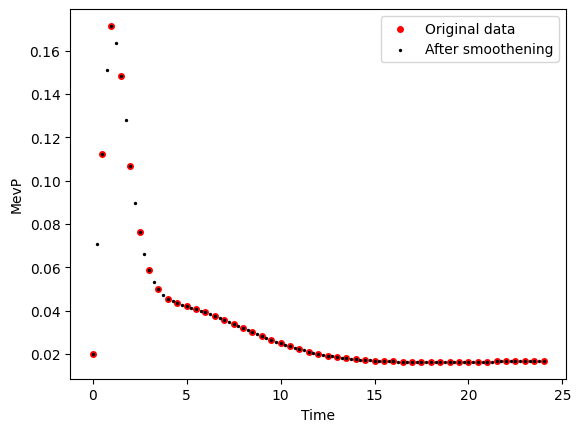

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


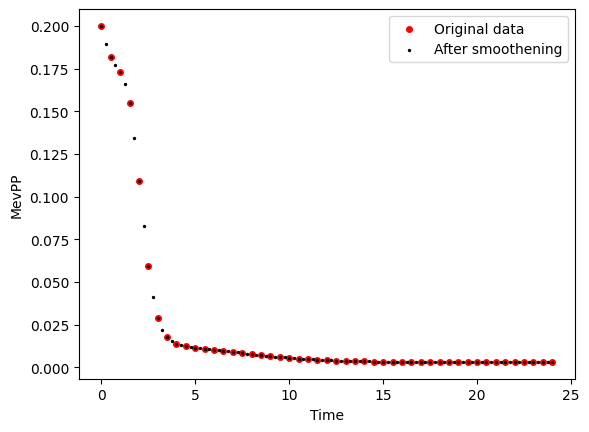

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


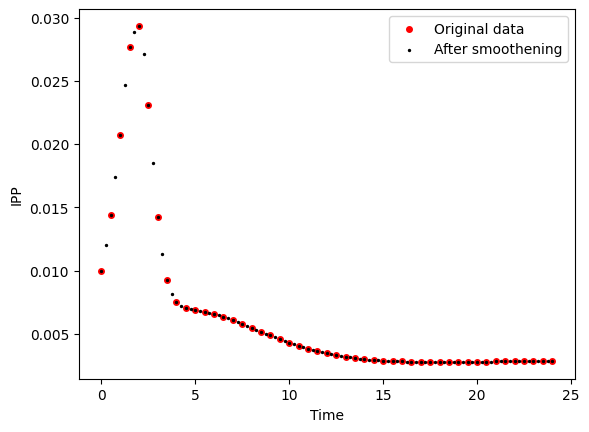

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


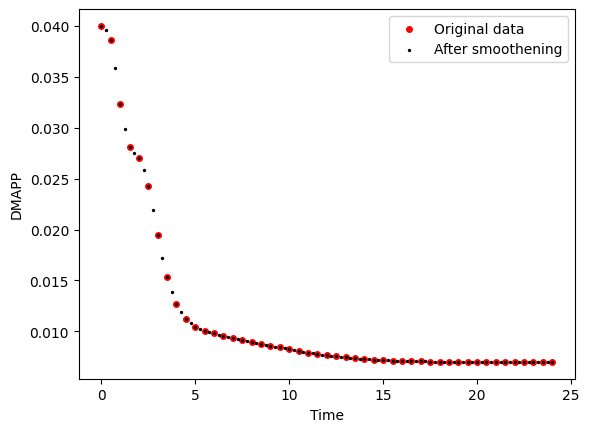

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


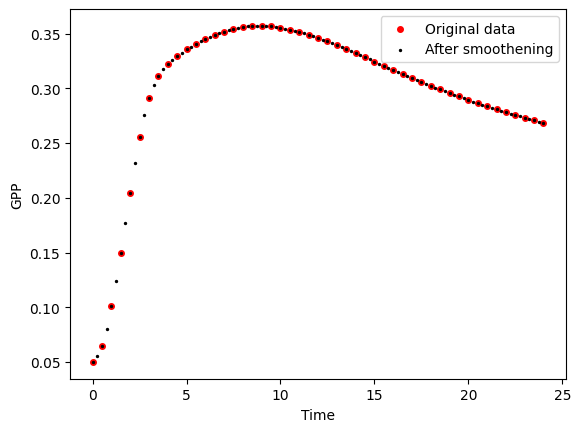

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


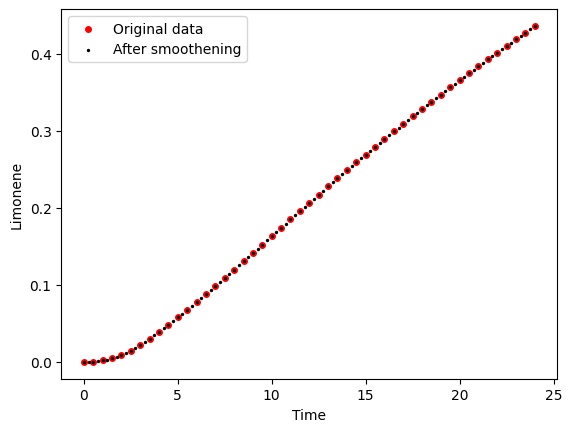

Strain Strain 2


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


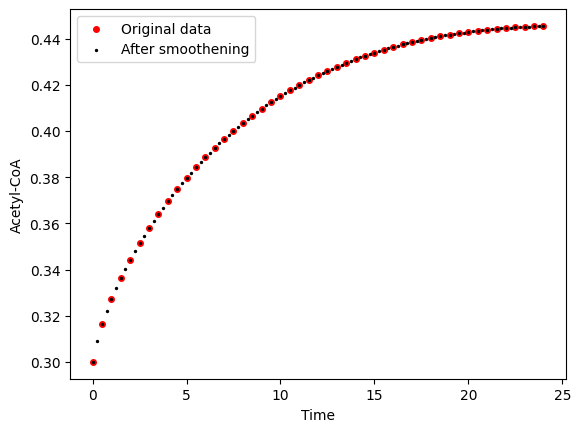

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


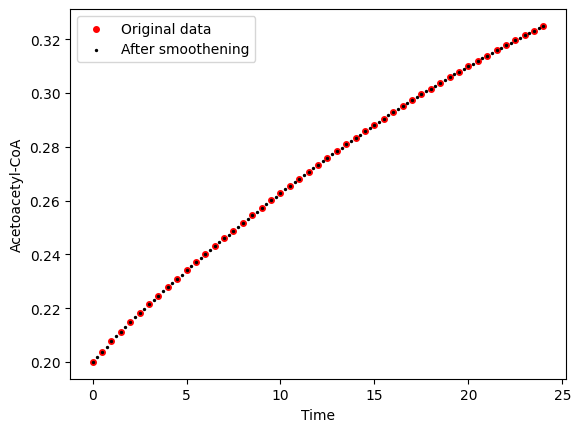

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


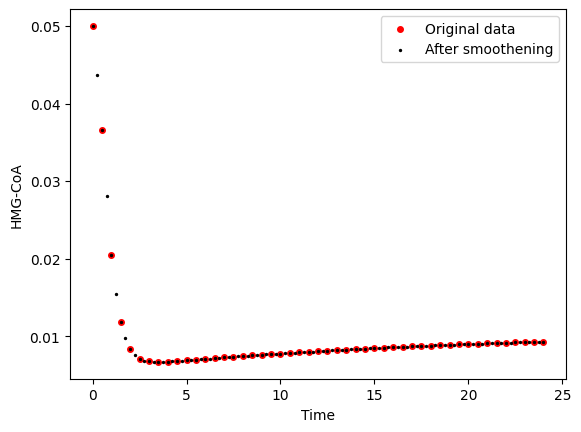

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


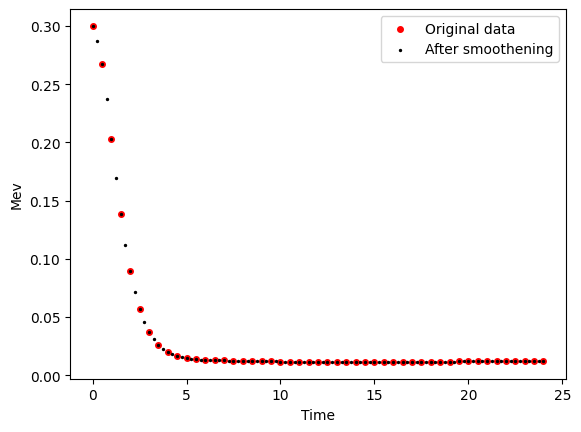

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


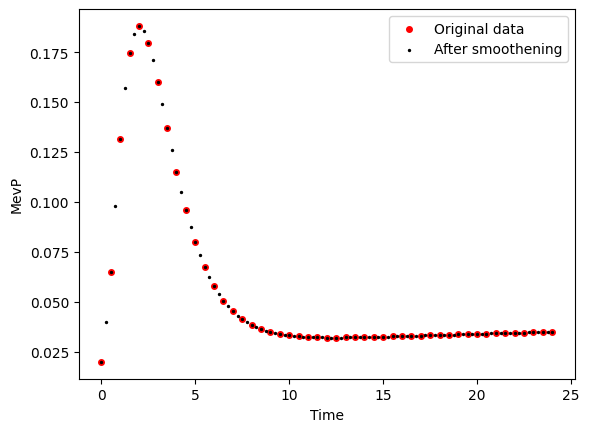

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


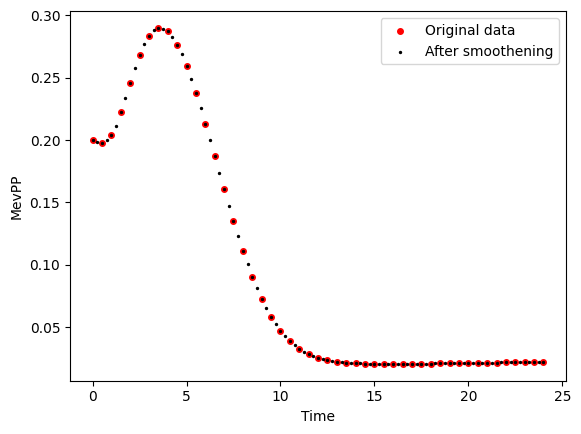

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


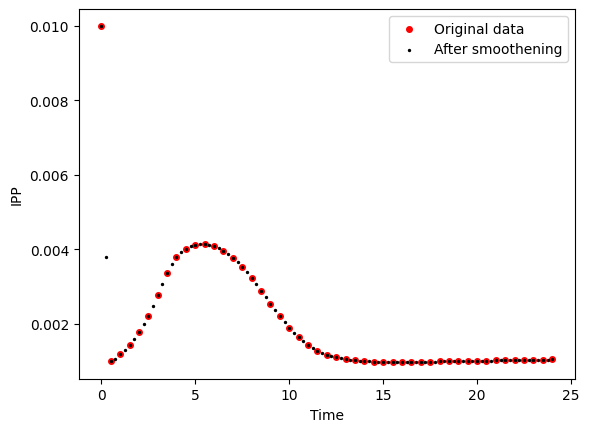

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


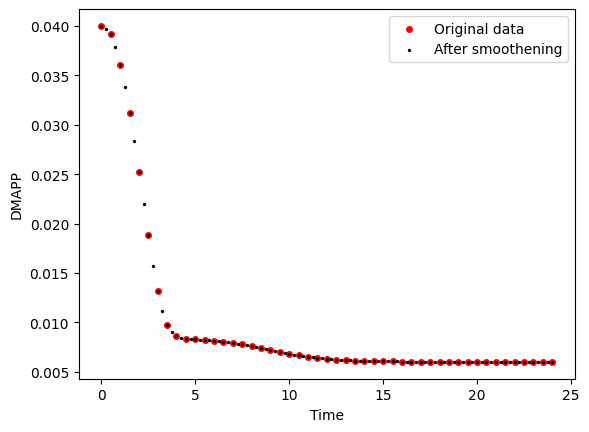

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


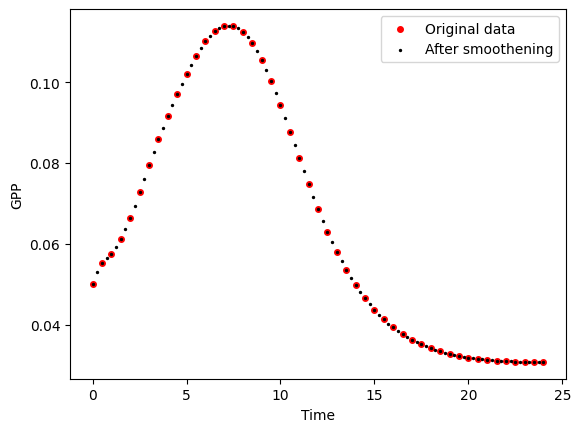

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


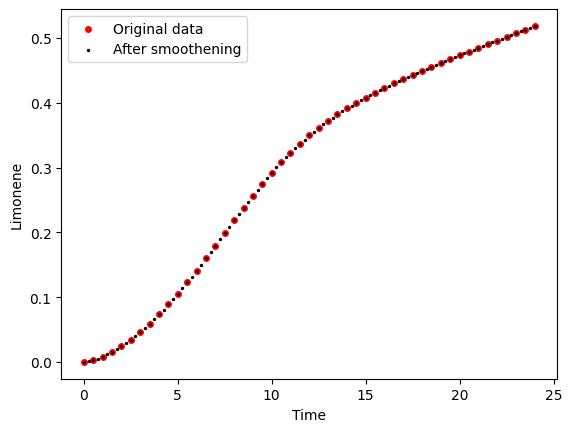

Strain Strain 3


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


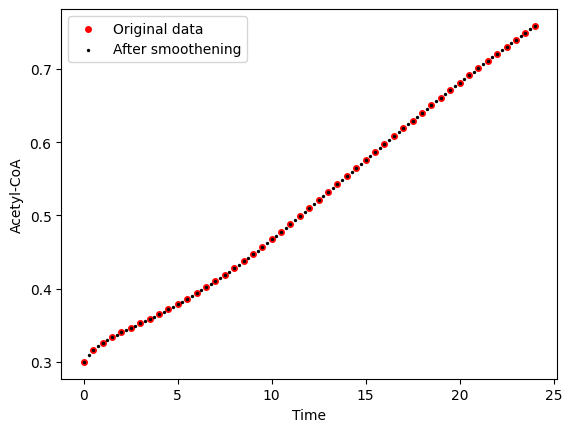

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


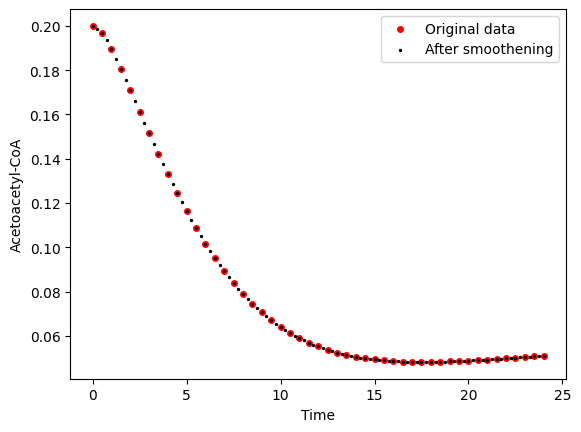

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


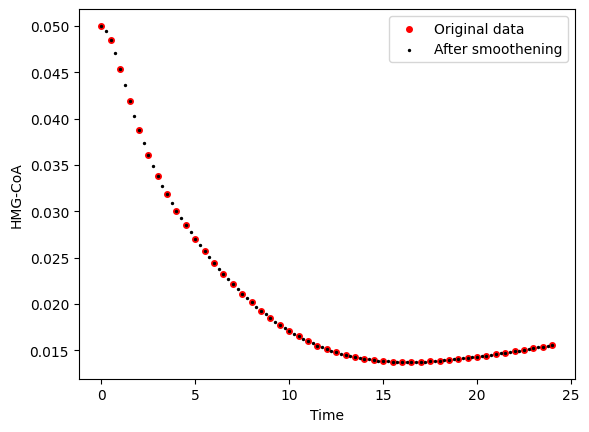

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


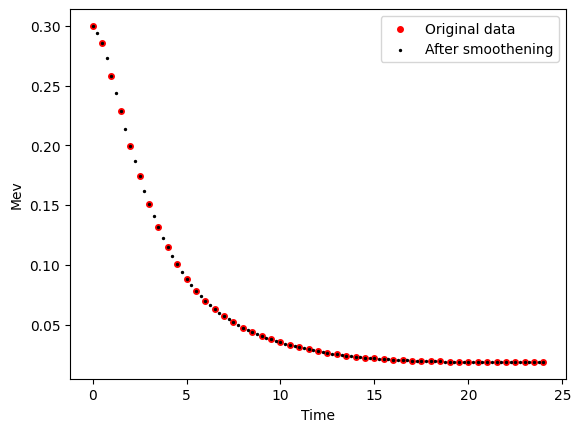

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


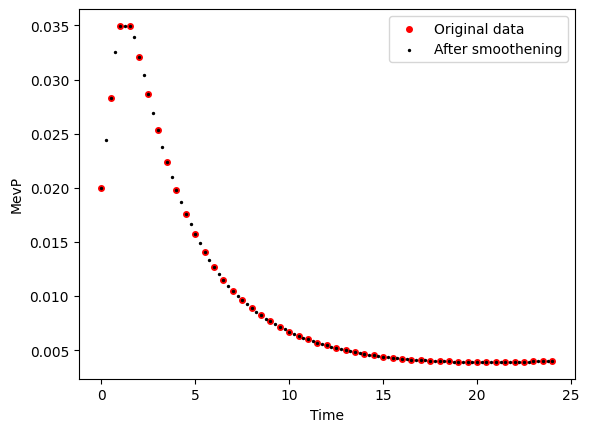

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


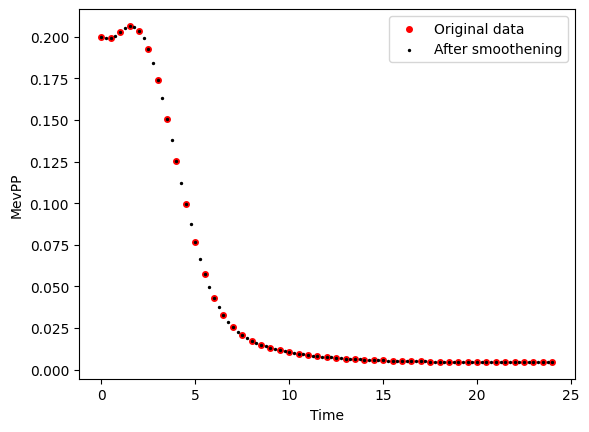

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


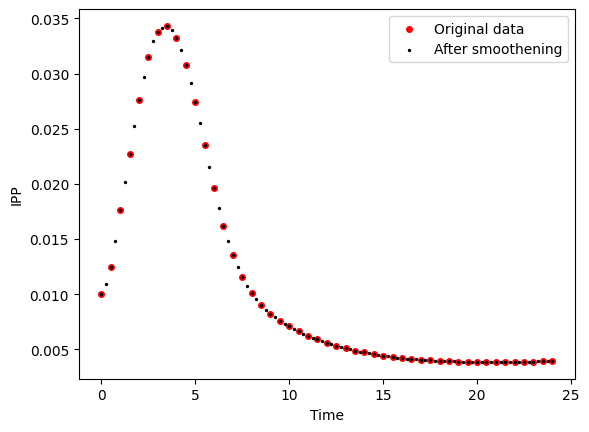

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


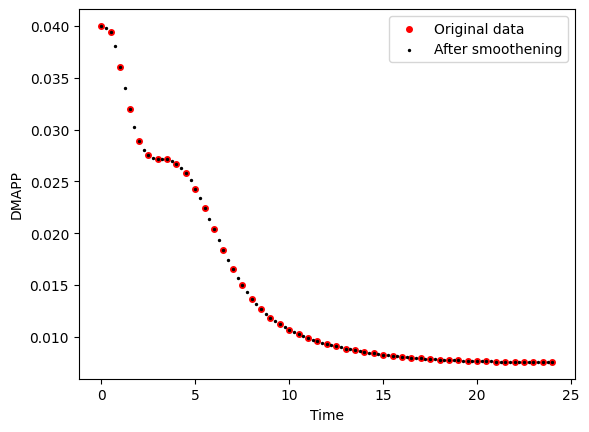

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


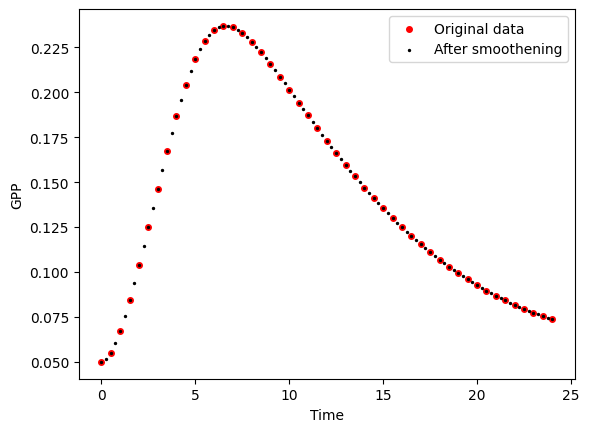

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


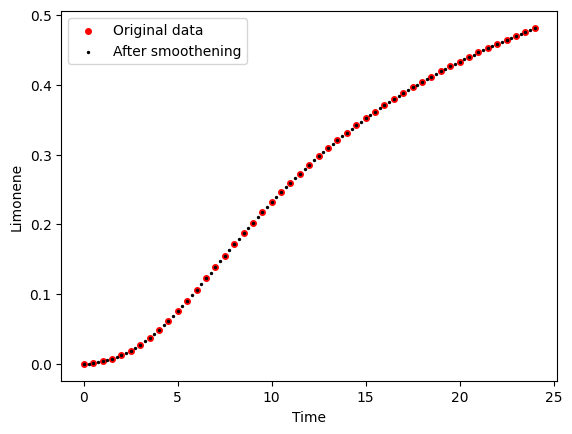

Strain WT


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


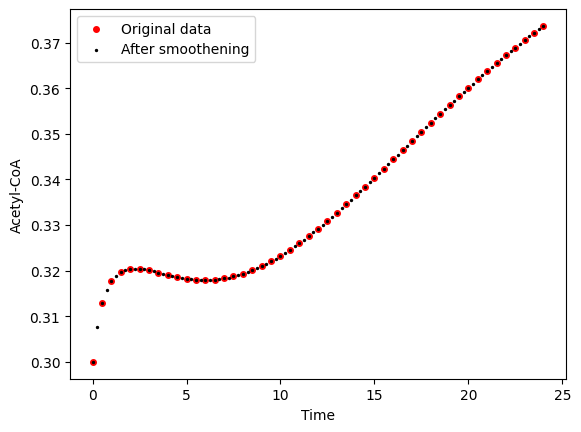

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


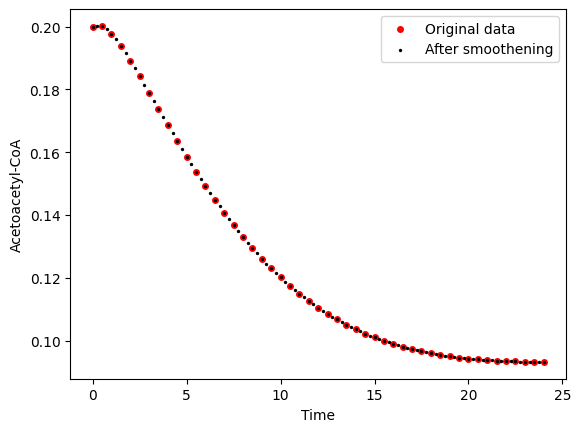

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


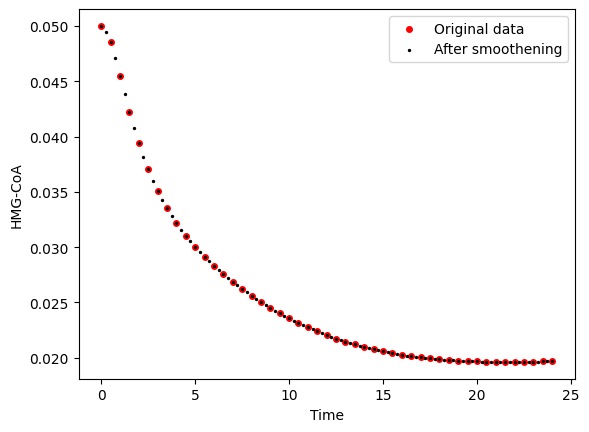

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


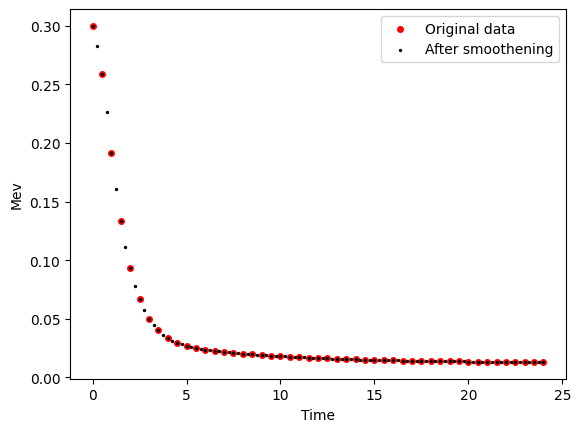

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


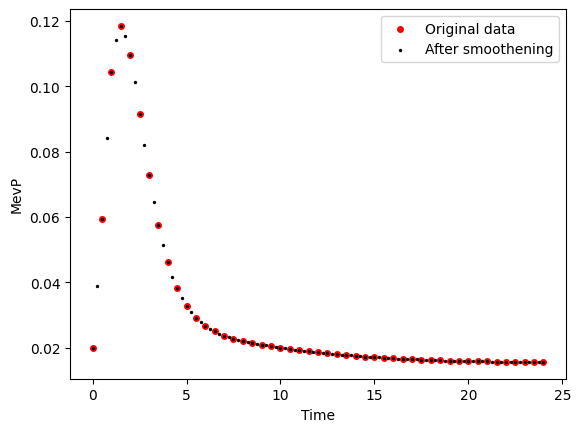

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


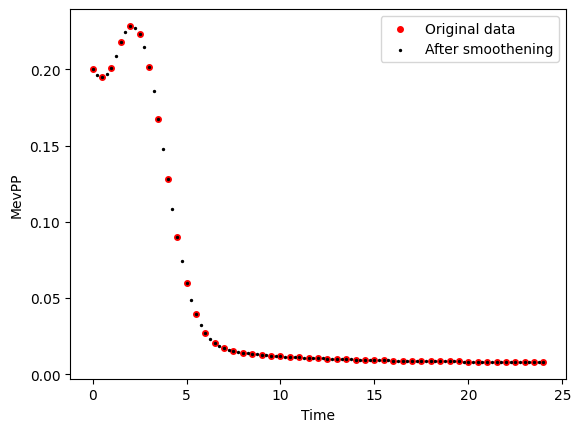

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


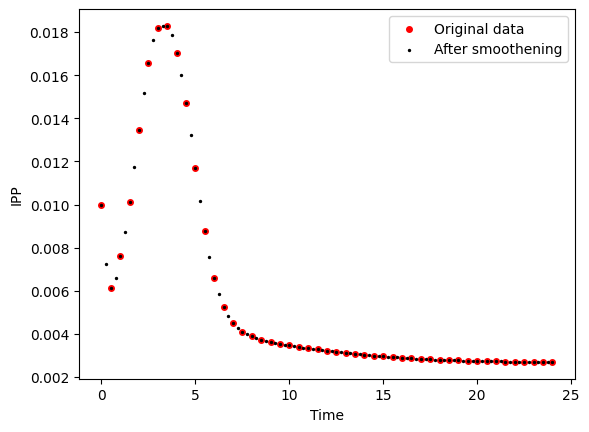

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


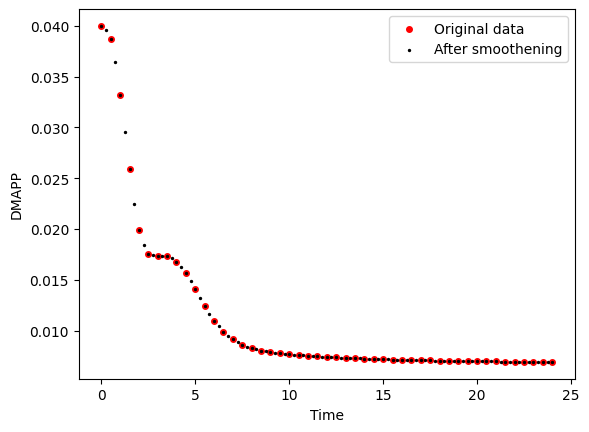

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


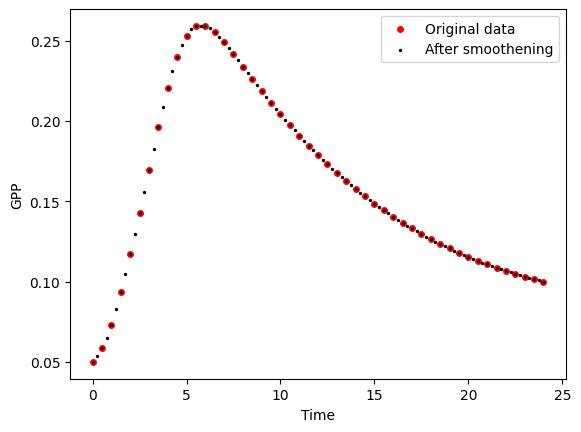

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


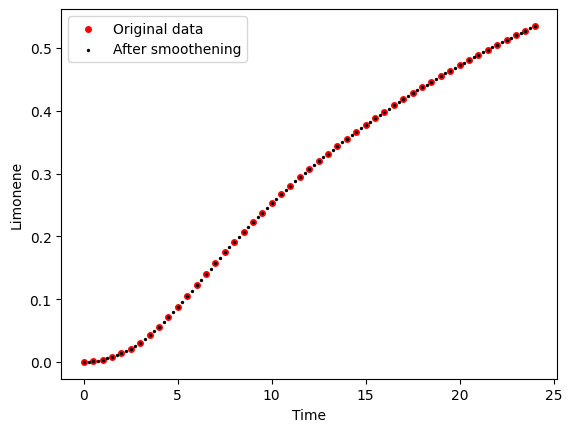

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


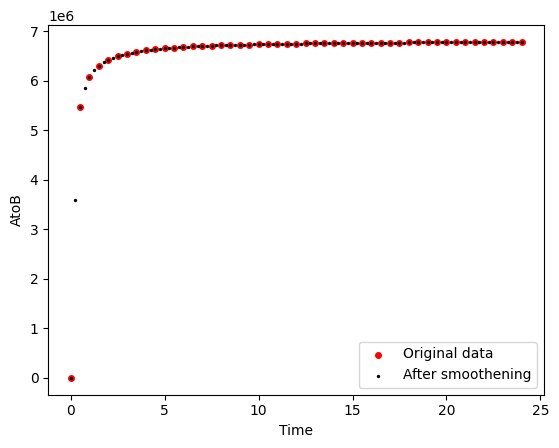

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


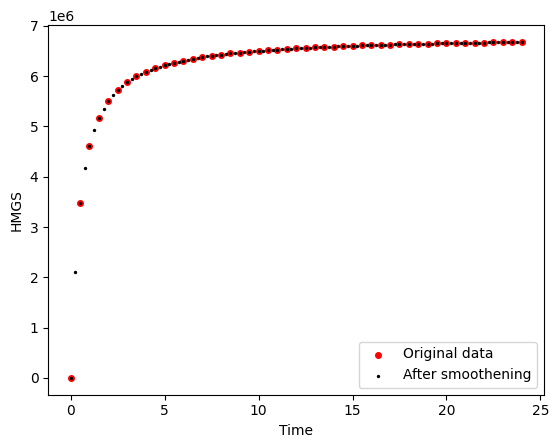

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


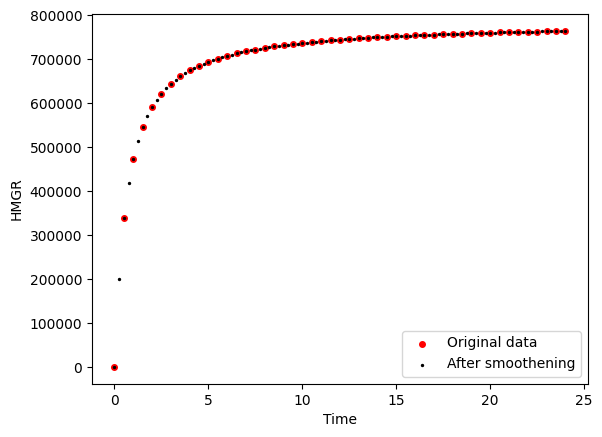

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


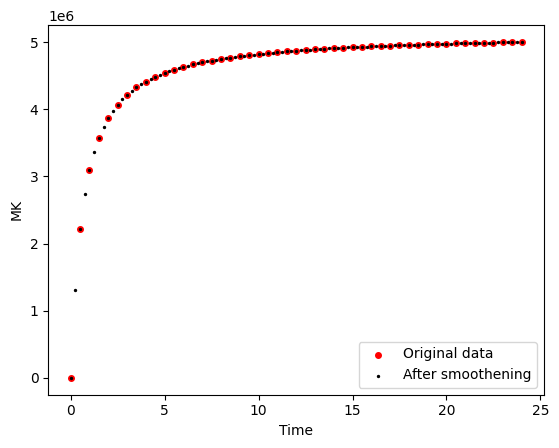

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


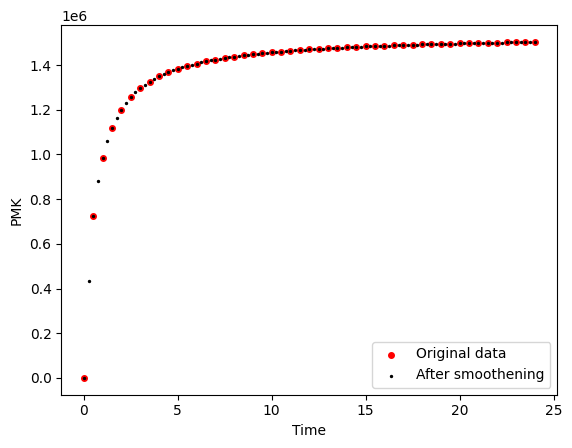

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


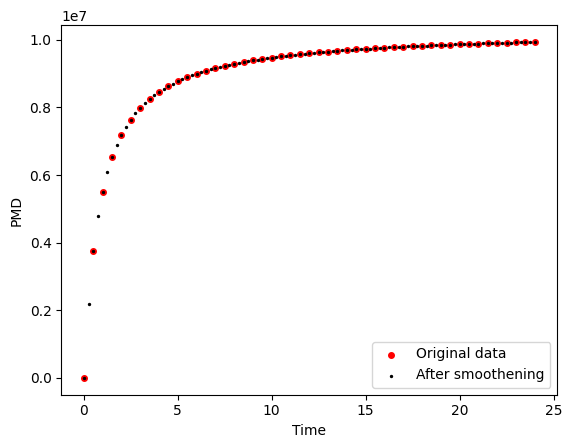

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


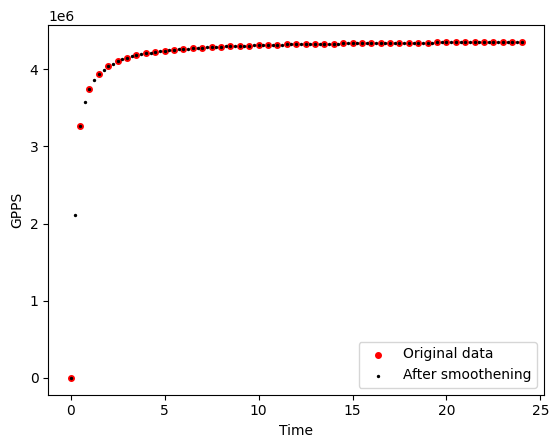

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


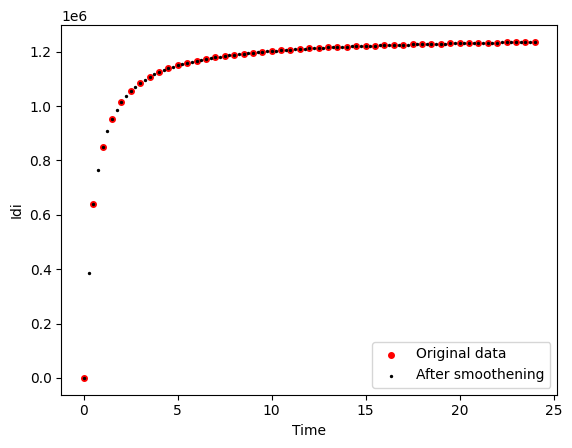

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


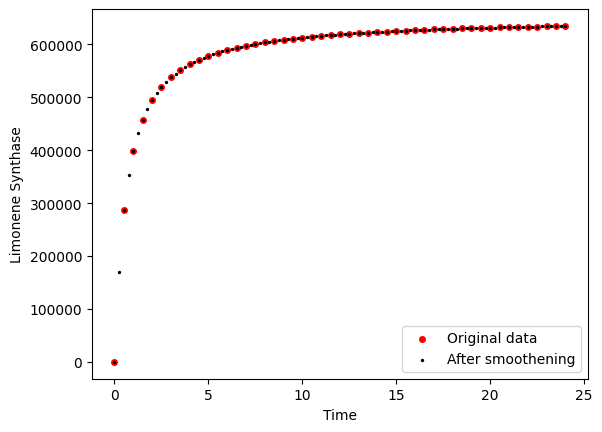

Strain Strain 2


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


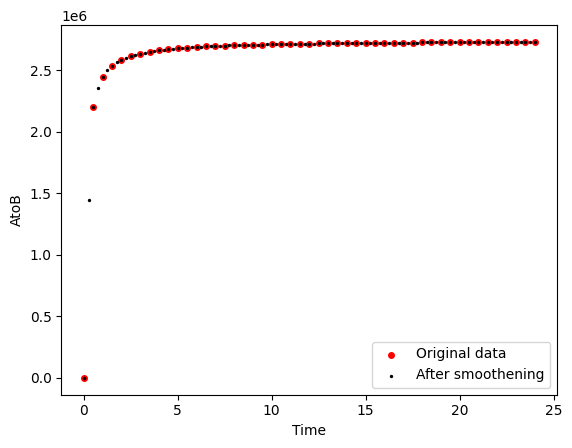

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


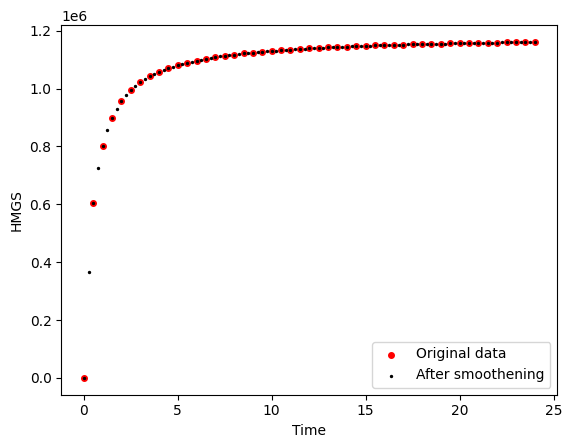

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


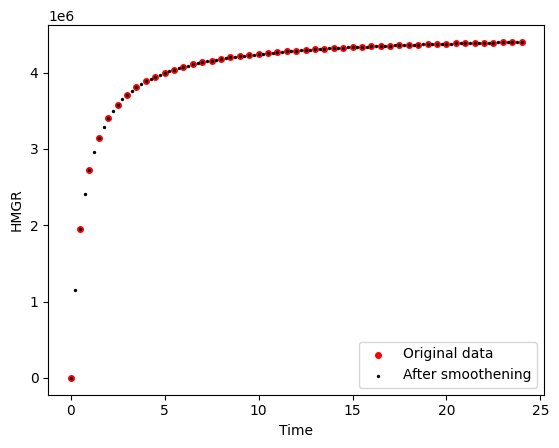

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


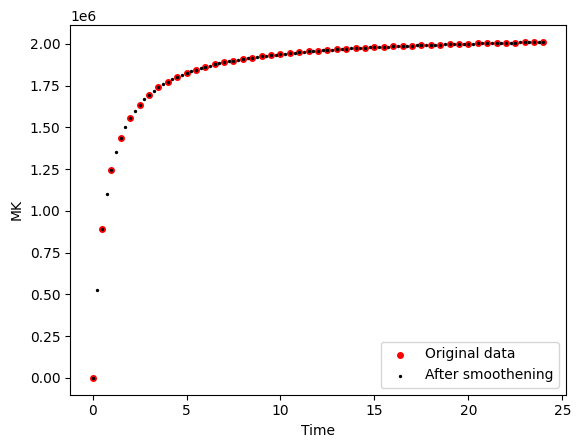

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


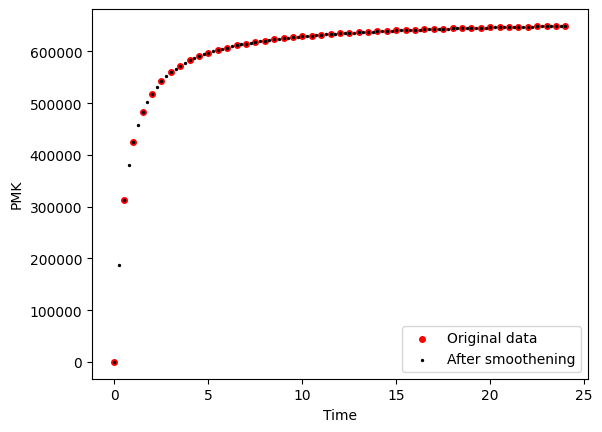

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


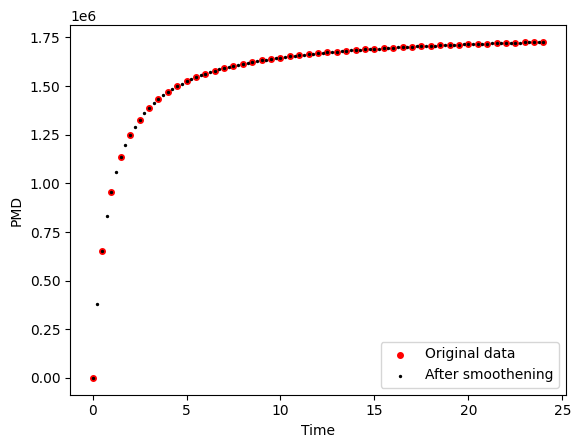

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


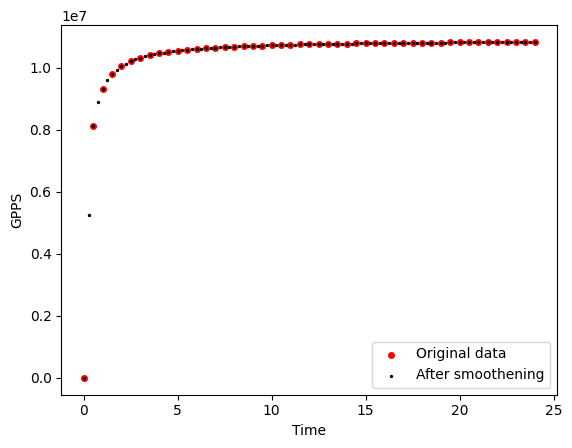

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


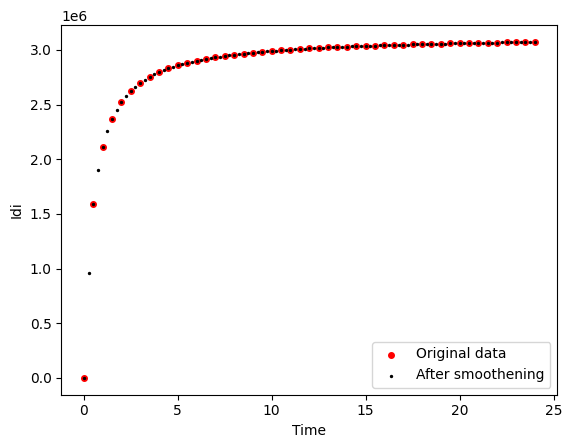

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


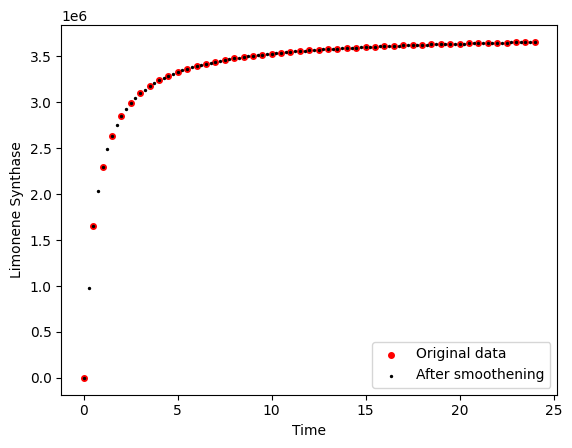

Strain Strain 3


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


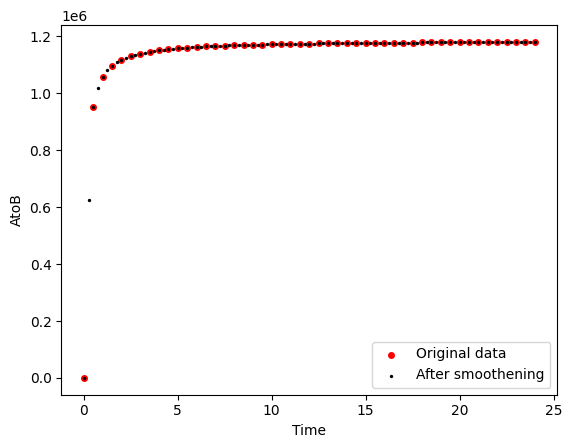

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


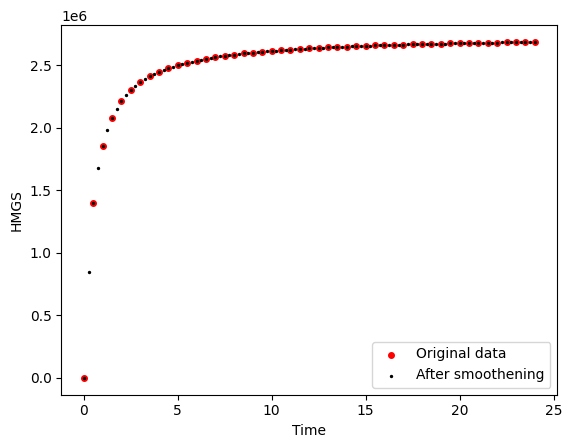

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


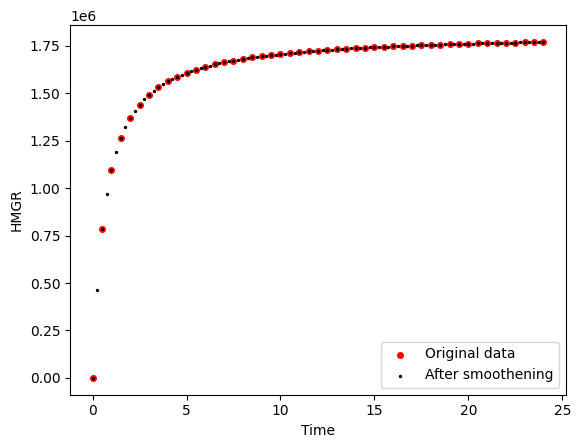

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


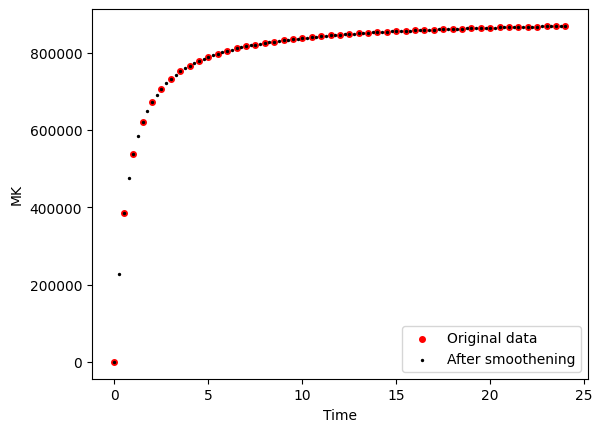

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


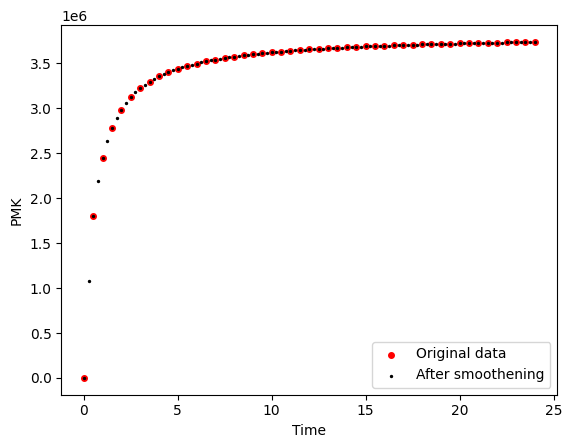

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


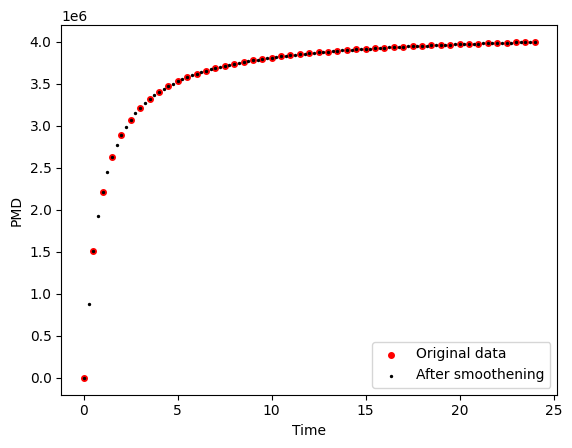

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


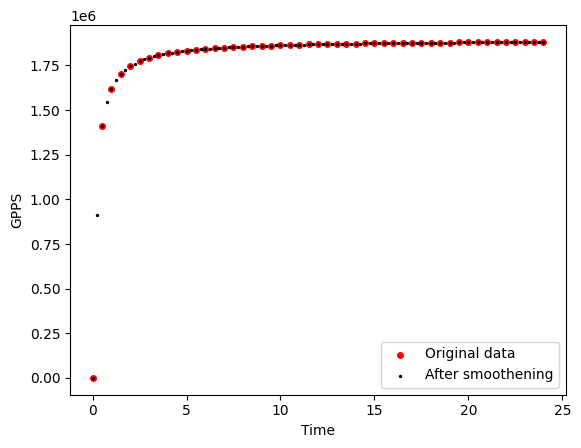

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


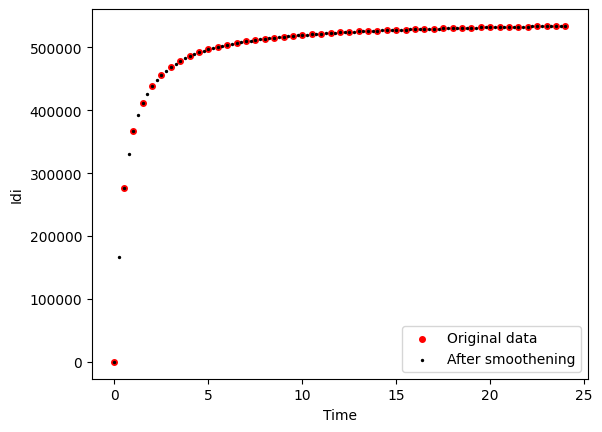

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


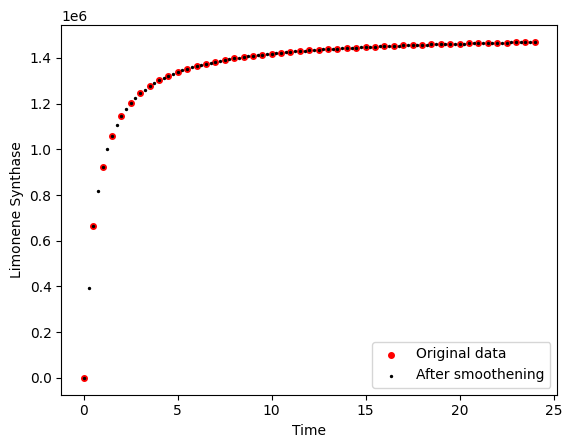

Strain WT


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


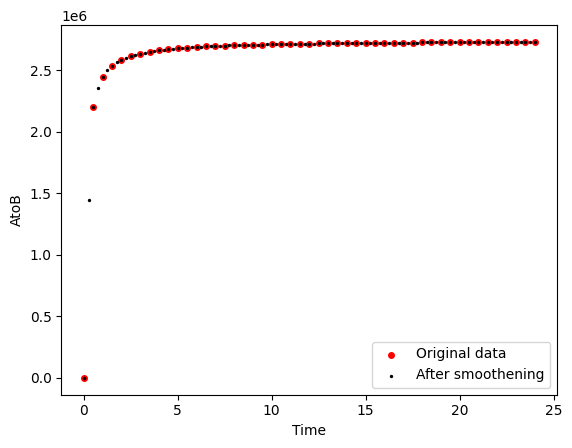

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


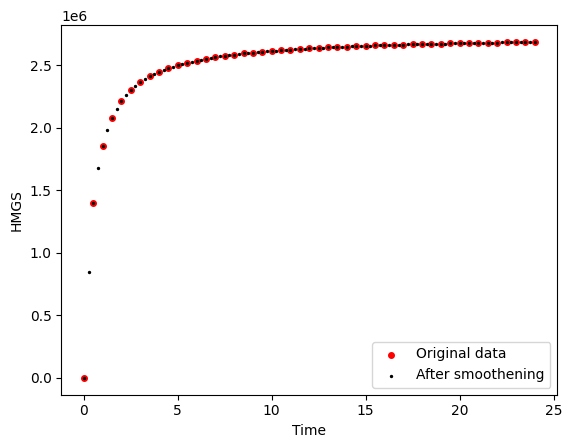

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


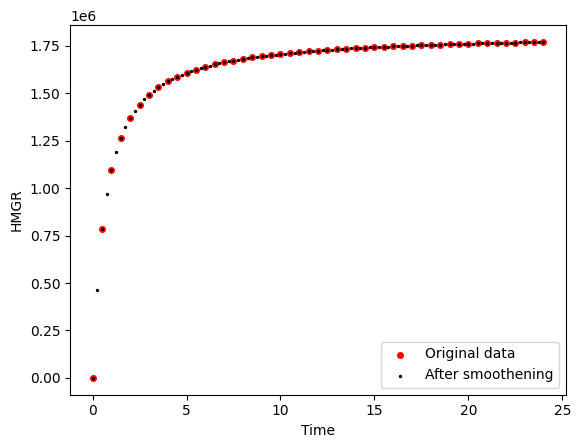

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


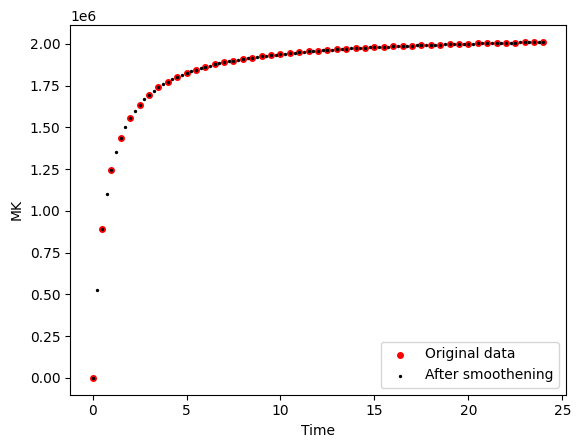

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


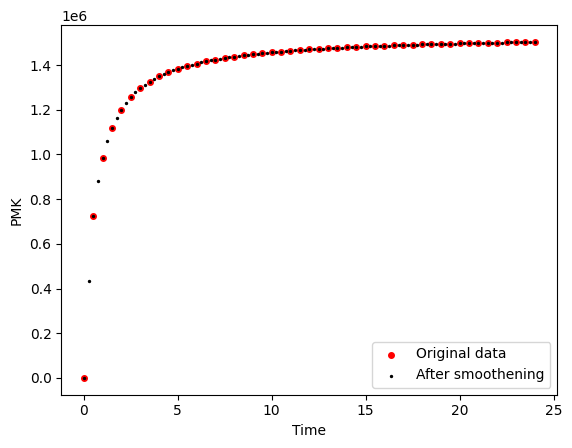

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


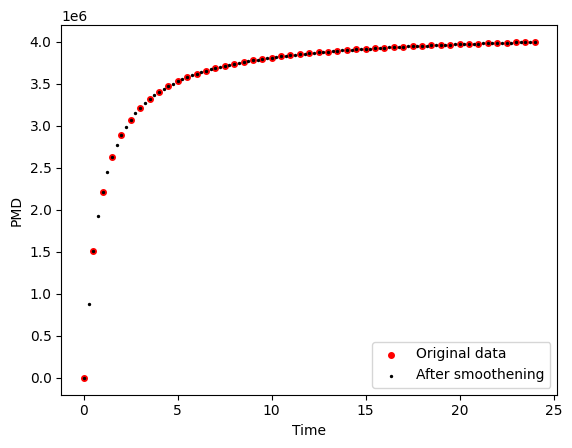

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


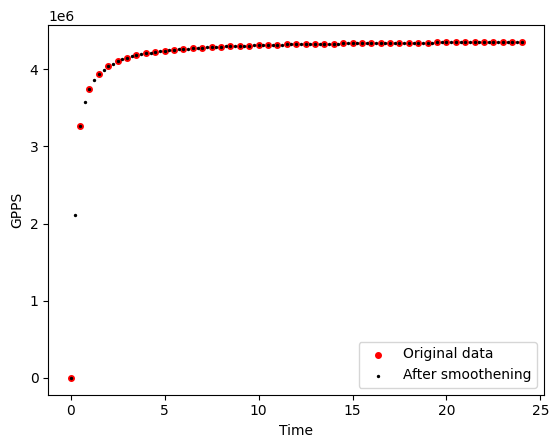

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


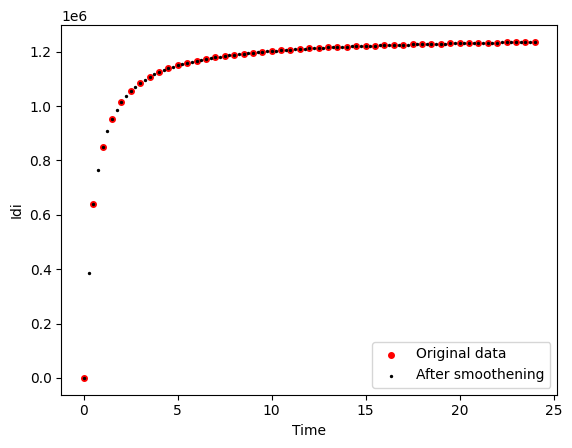

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


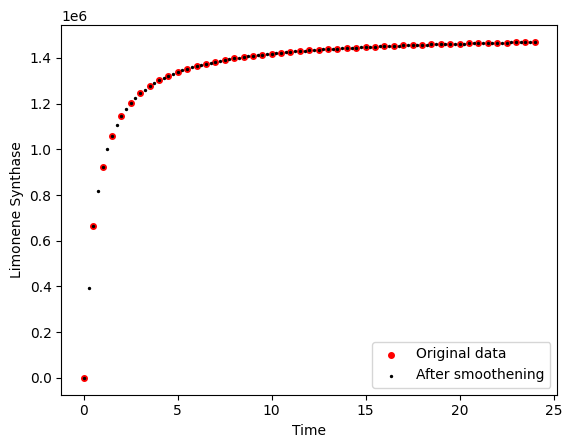

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.298687        0.200372  0.054724  0.249416  0.070715   
         0.50    0.295498        0.200425  0.060938  0.195920  0.112245   
         0.75    0.286308        0.198105  0.069380  0.132728  0.150818   
         1.00    0.272992        0.193767  0.078634  0.079861  0.171375   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.370558        0.093309  0.019650  0.013135  0.015658   
         23.25   0.371355        0.093283  0.019659  0.013121  0.015650   
         23.50   0.372140        0.093264  0.019669  0.013108  0.015644   
         23.75   0.372913        0.093253  0.019680  0.013096  0.015638   
         24.00   0.373674        0.093246  0.019692  0.013086  0.015634   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.189324  0.011997  0.039600  0.055364  0.000154  ...   
         0.50   0.181601  0.014419  0.038643  0.064898  0.000488  ...   
         0.75   0.177386  0.017385  0.035860  0.080339  0.001065  ...   
         1.00   0.173169  0.020703  0.032371  0.100826  0.001928  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.008076  0.002704  0.006927  0.103119  0.520339  ...   
         23.25  0.008068  0.002702  0.006924  0.102294  0.524109  ...   
         23.50  0.008061  0.002701  0.006921  0.101497  0.527850  ...   
         23.75  0.008054  0.002700  0.006919  0.100726  0.531564  ...   
         24.00  0.008049  0.002700  0.006916  0.099981  0.535250  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.014025        0.008572  0.011243 -0.169234  0.212296   
         0.25    -0.010464        0.000531  0.022780 -0.219436  0.193524   
         0.50    -0.029516       -0.006482  0.030717 -0.238189  0.158871   
         0.75    -0.043131       -0.012467  0.035053 -0.225496  0.108337   
         1.00    -0.052856       -0.018477  0.035810 -0.172344  0.029683   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003212       -0.000117  0.000032 -0.000059 -0.000034   
         23.25    0.003164       -0.000087  0.000037 -0.000053 -0.000028   
         23.50    0.003116       -0.000061  0.000042 -0.000048 -0.000023   
         23.75    0.003068       -0.000037  0.000046 -0.000043 -0.000019   
         24.00    0.003019       -0.000014  0.000050 -0.000039 -0.000014   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.056834  0.005381  0.005004  0.005177  0.000238  
         0.25  -0.034679  0.008818 -0.003444  0.030545  0.000951  
         0.50  -0.021398  0.011387 -0.009115  0.052533  0.001819  
         0.75  -0.016989  0.013089 -0.012009  0.071141  0.002842  
         1.00  -0.020168  0.014881 -0.012510  0.087311  0.004033  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.000035 -0.000006 -0.000012 -0.003355  0.015138  
         23.25 -0.000031 -0.000005 -0.000011 -0.003244  0.015022  
         23.50 -0.000027 -0.000004 -0.000011 -0.003136  0.014909  
         23.75 -0.000024 -0.000003 -0.000010 -0.003030  0.014799  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

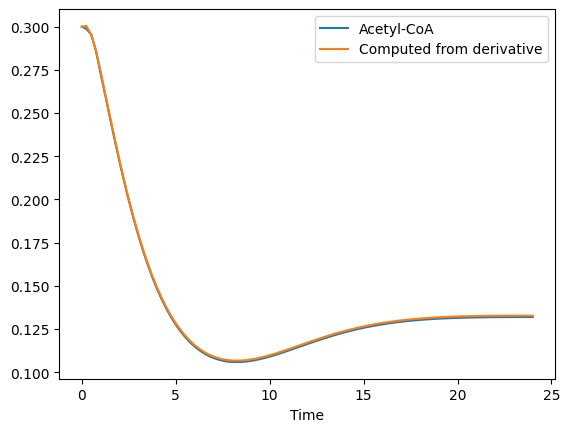

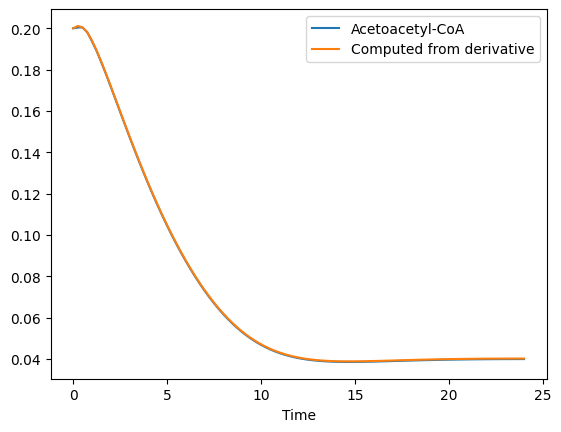

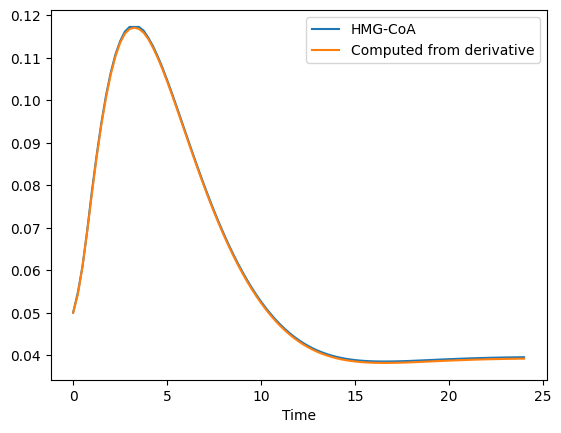

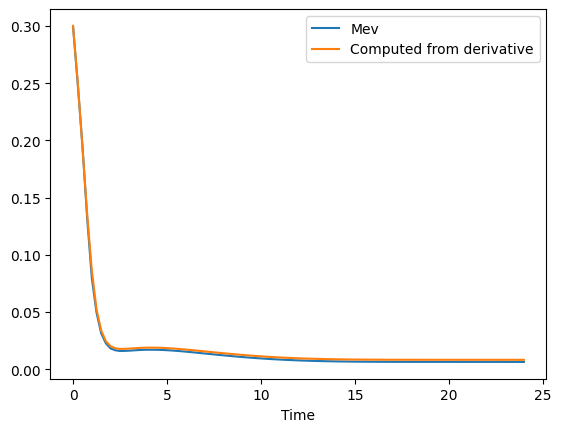

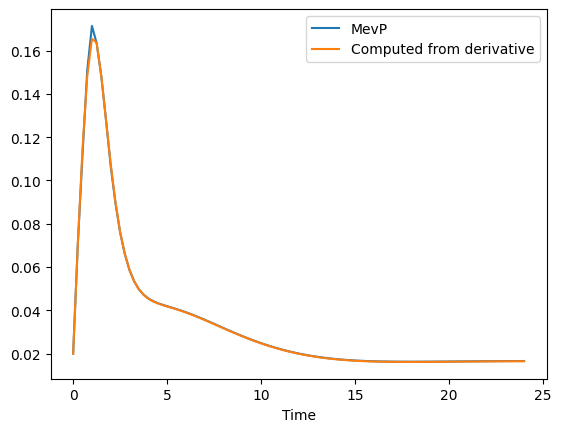

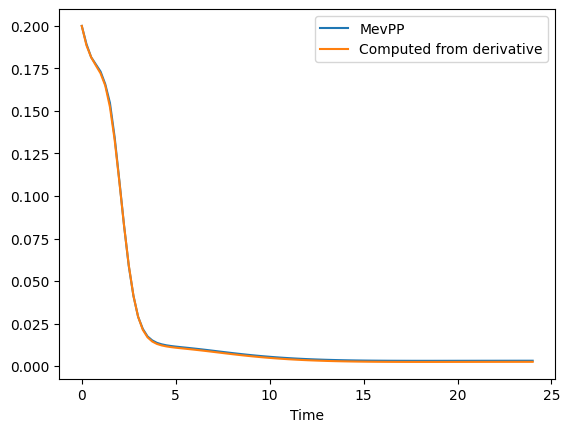

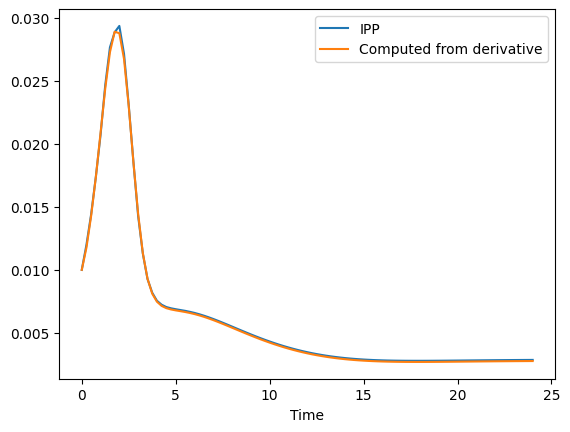

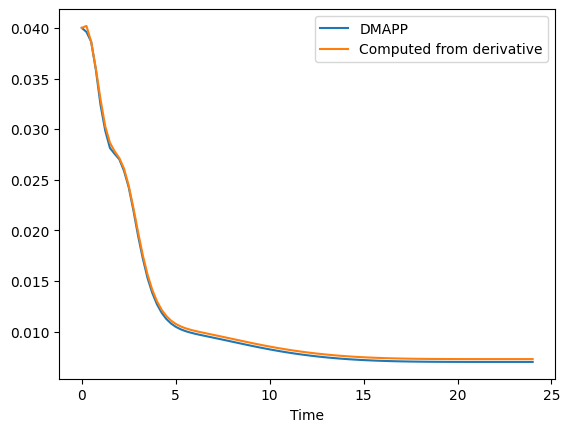

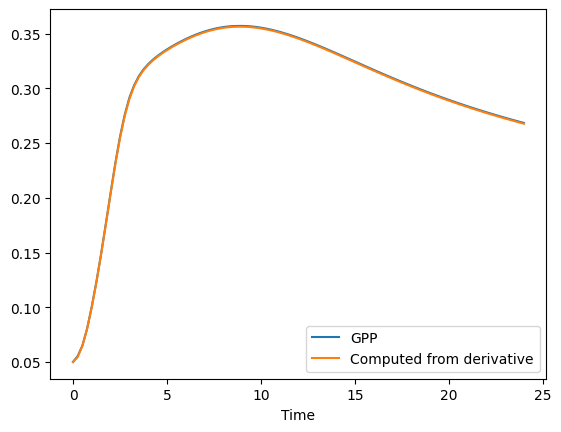

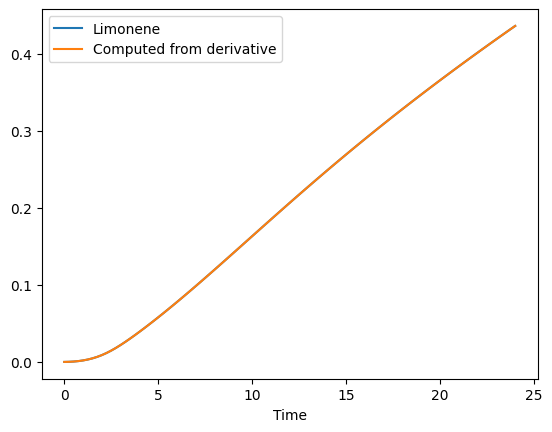

'Time profile from derivative vs. actual profile for Strain 2'

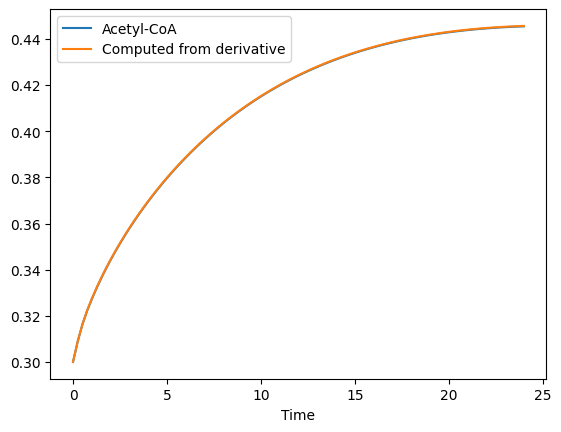

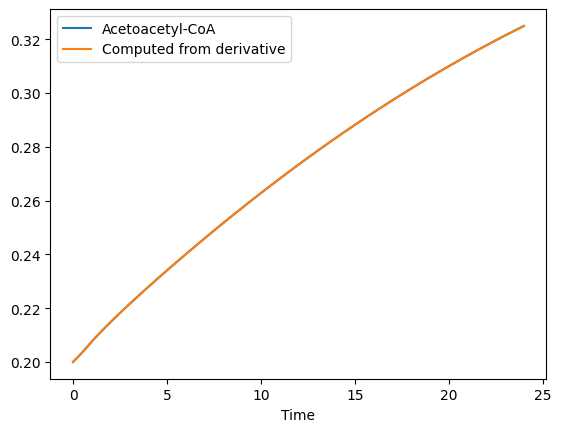

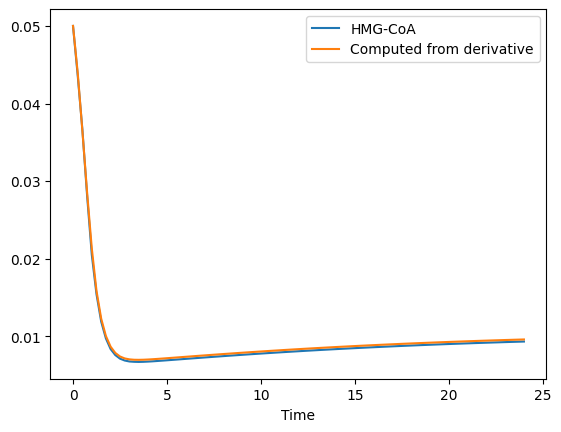

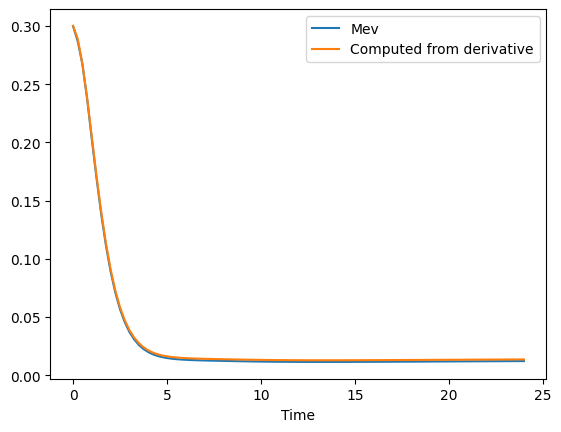

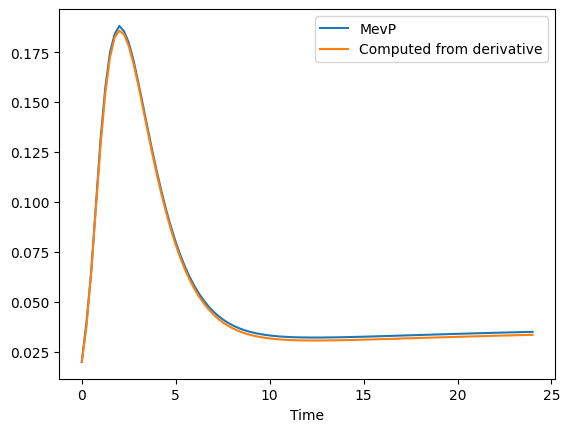

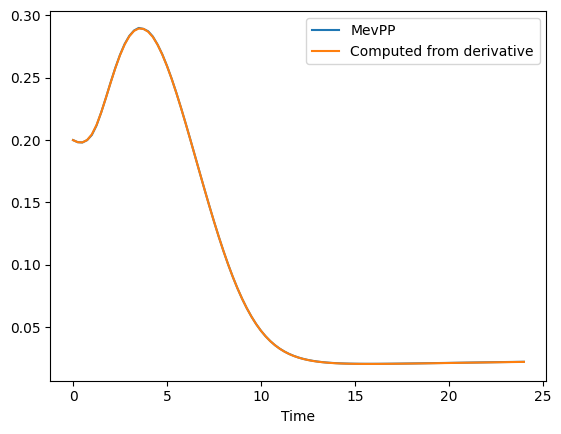

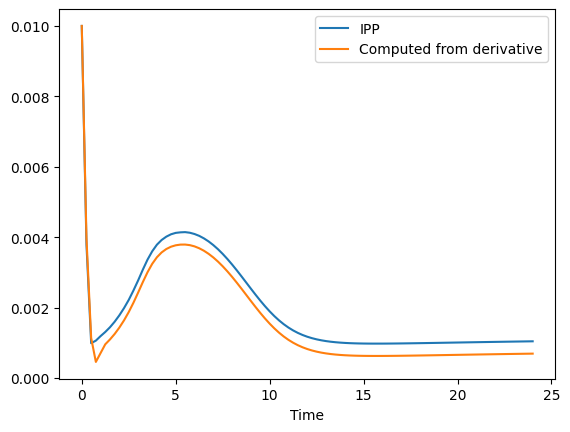

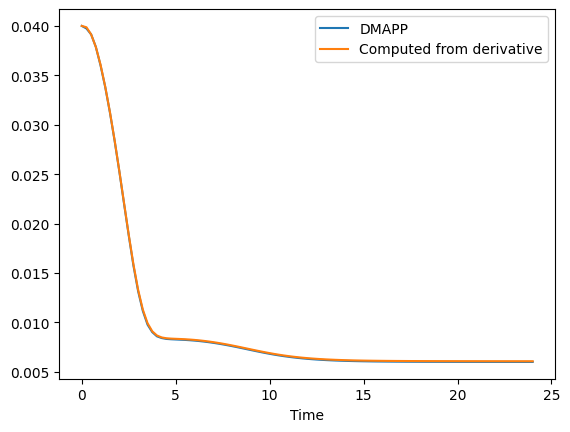

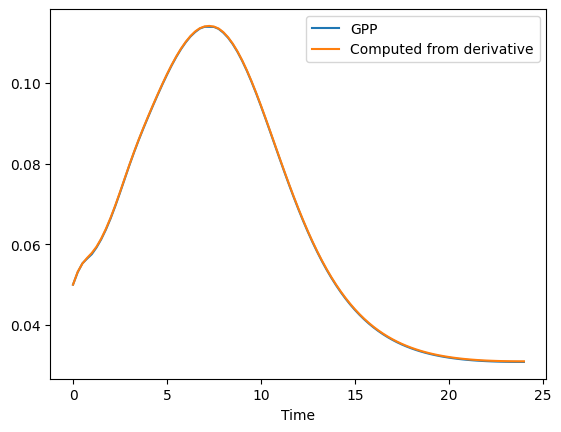

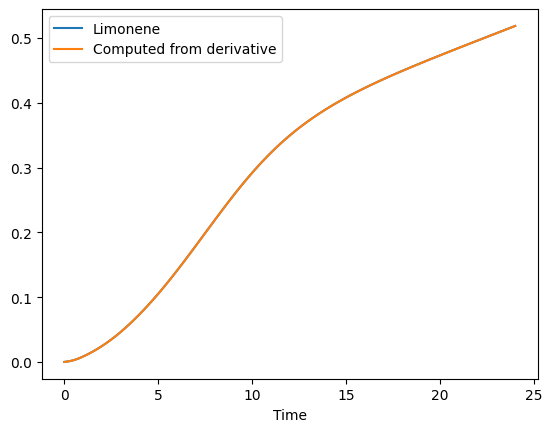

'Time profile from derivative vs. actual profile for Strain 3'

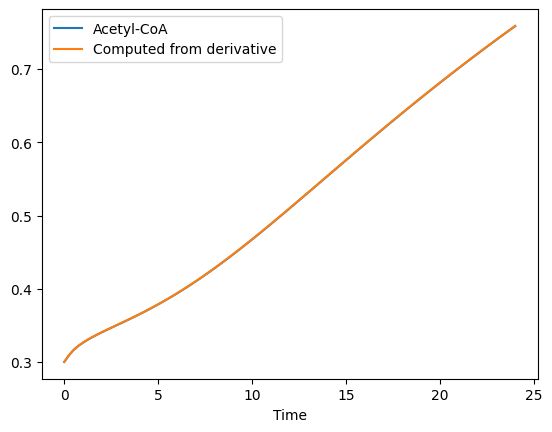

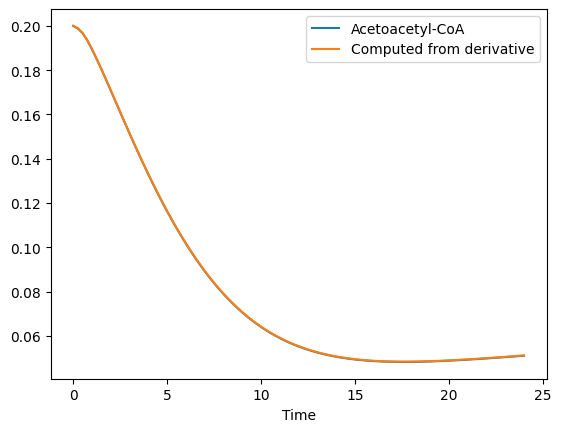

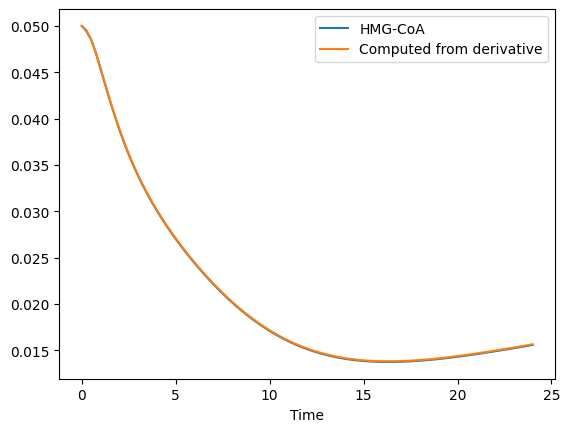

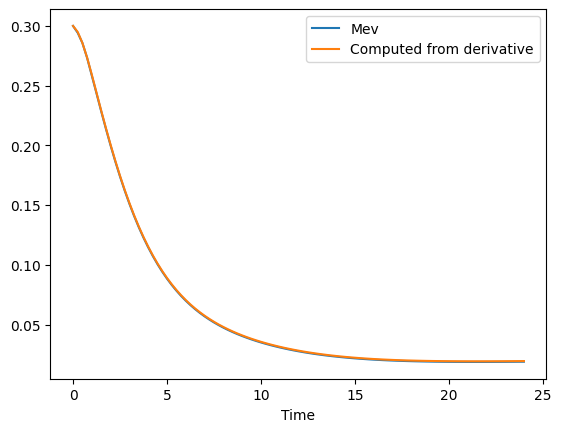

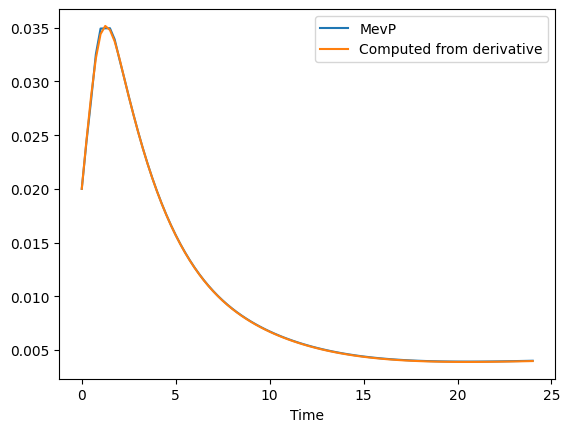

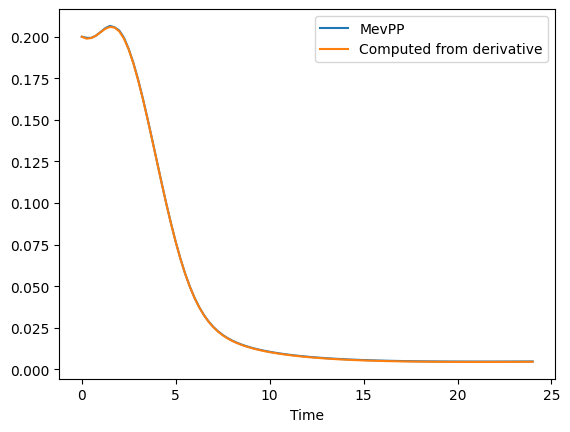

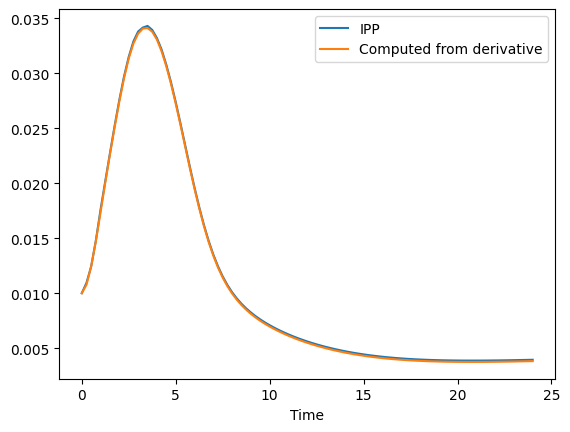

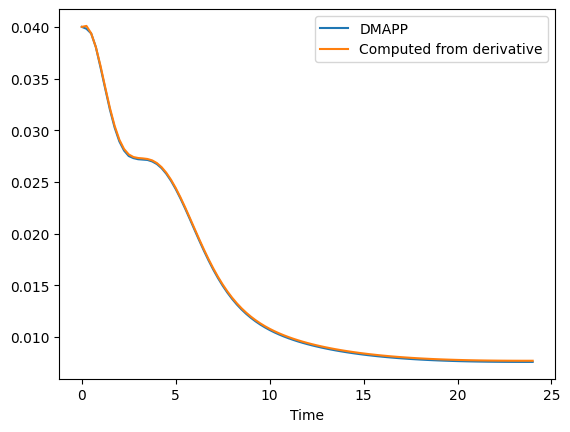

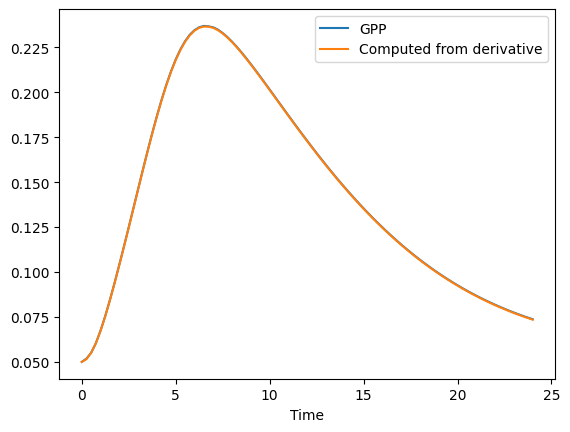

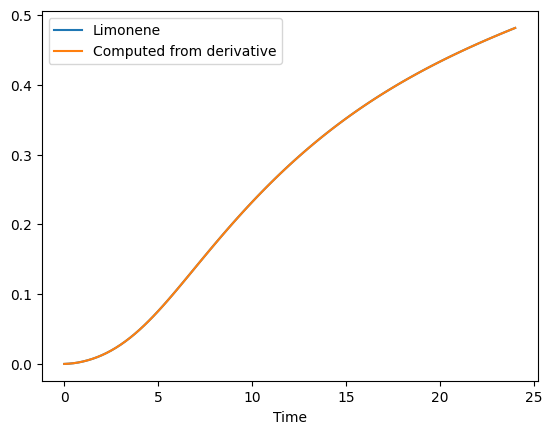

'Time profile from derivative vs. actual profile for WT'

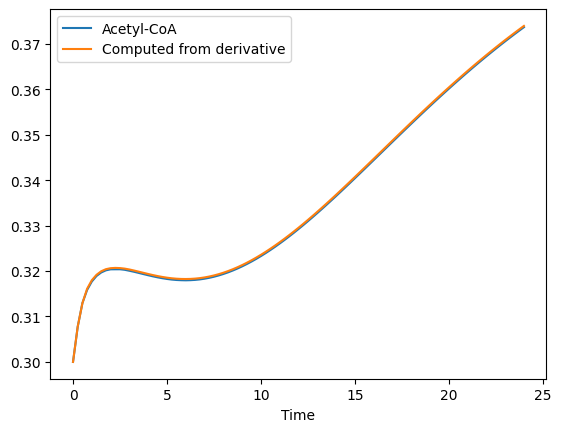

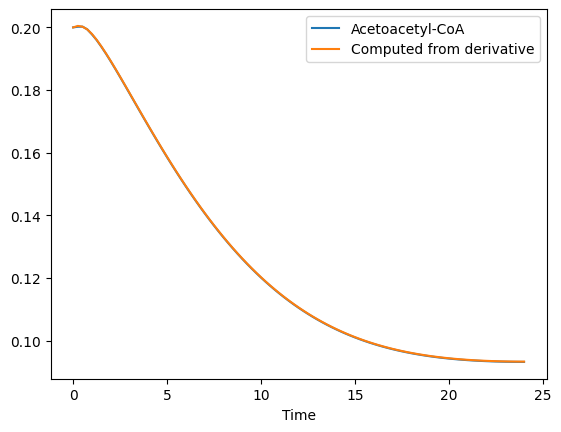

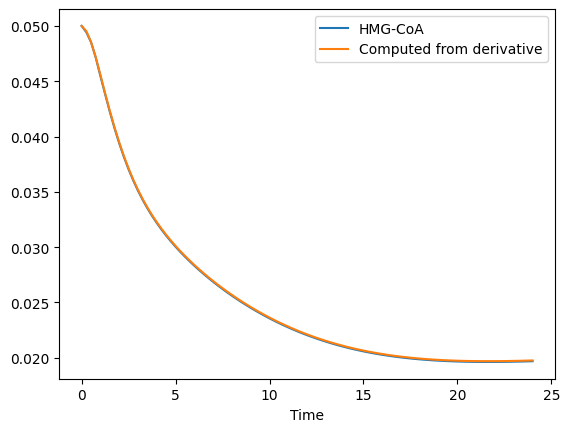

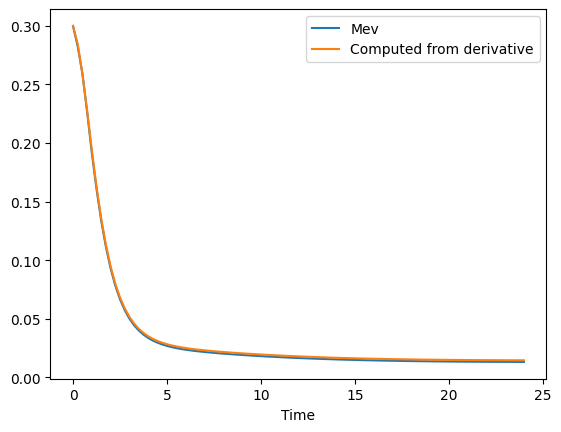

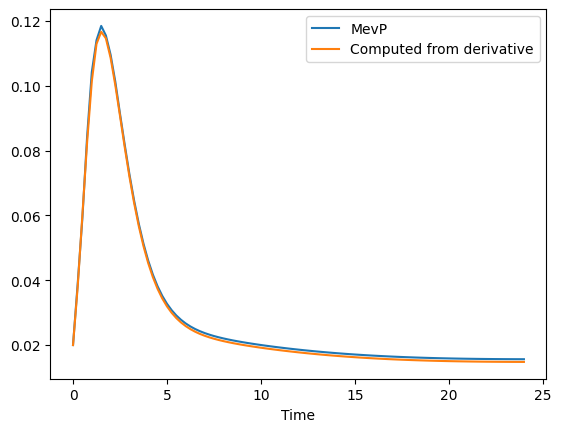

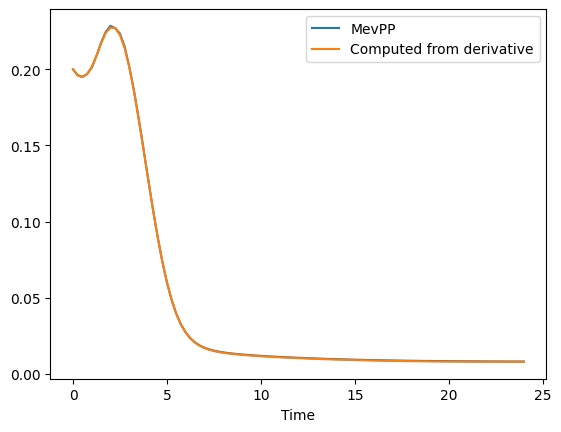

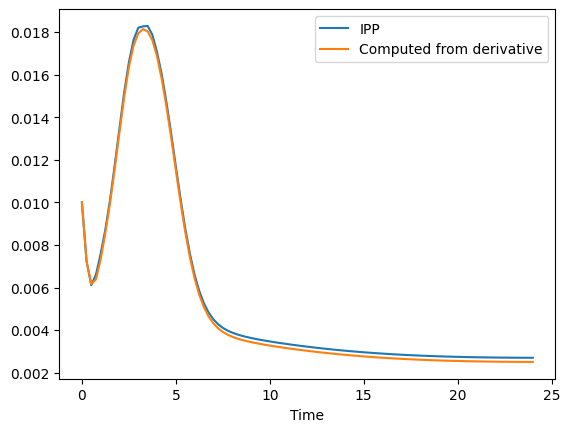

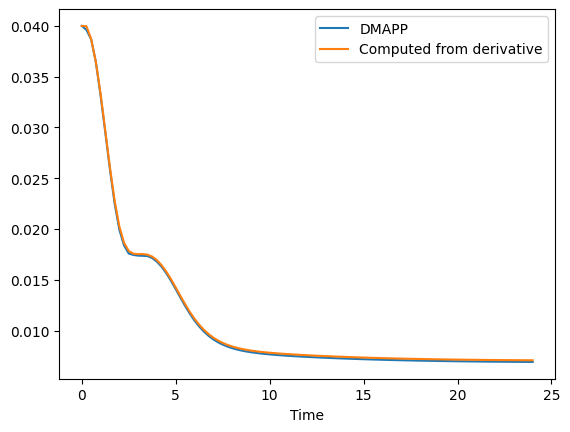

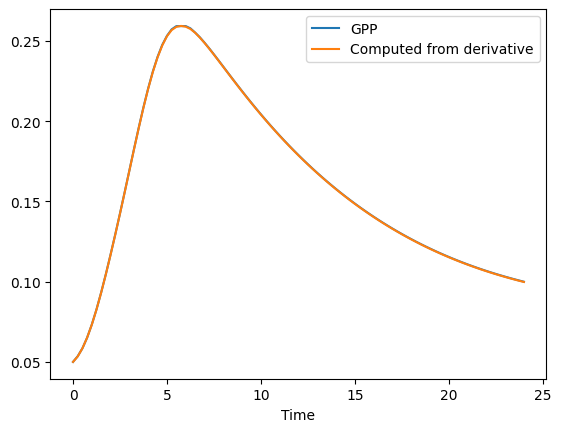

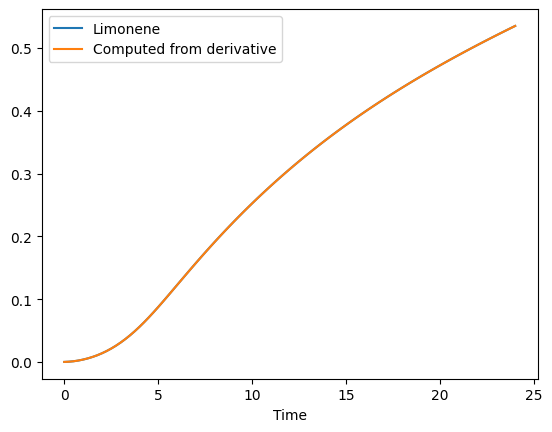

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   3.589052e+06  2.111237e+06  2.008718e+05  1.311689e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.865920e+06  4.166035e+06  4.191051e+05  2.738184e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.336546e+05  2.178306e+06  2.110608e+06  3.875298e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.801888e+05  4.773919e+06  3.574431e+06  7.666082e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.700158e+05   0.298687        0.200372  0.054724   
         0.50       2.866143e+05   0.295498        0.200425  0.060938   
         0.75       3.527646e+05   0.286308        0.198105  0.069380   
         1.00       3.981392e+05   0.272992        0.193767  0.078634   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.370558        0.093309  0.019650   
         23.25      1.468435e+06   0.371355        0.093283  0.019659   
         23.50      1.468851e+06   0.372140        0.093264  0.019669   
         23.75      1.469260e+06   0.372913        0.093253  0.019680   
         24.00      1.469659e+06   0.373674        0.093246  0.019692   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.249416  0.070715  0.189324  0.011997  0.039600  0.055364   
         0.50   0.195920  0.112245  0.181601  0.014419  0.038643  0.064898   
         0.75   0.132728  0.150818  0.177386  0.017385  0.035860  0.080339   
         1.00   0.079861  0.171375  0.173169  0.020703  0.032371  0.100826   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.013135  0.015658  0.008076  0.002704  0.006927  0.103119   
         23.25  0.013121  0.015650  0.008068  0.002702  0.006924  0.102294   
         23.50  0.013108  0.015644  0.008061  0.002701  0.006921 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.014025        0.008572  0.011243 -0.169234  0.212296   
         0.25    -0.010464        0.000531  0.022780 -0.219436  0.193524   
         0.50    -0.029516       -0.006482  0.030717 -0.238189  0.158871   
         0.75    -0.043131       -0.012467  0.035053 -0.225496  0.108337   
         1.00    -0.052856       -0.018477  0.035810 -0.172344  0.029683   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003212       -0.000117  0.000032 -0.000059 -0.000034   
         23.25    0.003164       -0.000087  0.000037 -0.000053 -0.000028   
         23.50    0.003116       -0.000061  0.000042 -0.000048 -0.000023   
         23.75    0.003068       -0.000037  0.000046 -0.000043 -0.000019   
         24.00    0.003019       -0.000014  0.000050 -0.000039 -0.000014   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.056834  0.005381  0.005004  0.005177  0.000238  
         0.25  -0.034679  0.008818 -0.003444  0.030545  0.000951  
         0.50  -0.021398  0.011387 -0.009115  0.052533  0.001819  
         0.75  -0.016989  0.013089 -0.012009  0.071141  0.002842  
         1.00  -0.020168  0.014881 -0.012510  0.087311  0.004033  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.000035 -0.000006 -0.000012 -0.003355  0.015138  
         23.25 -0.000031 -0.000005 -0.000011 -0.003244  0.015022  
         23.50 -0.000027 -0.000004 -0.000011 -0.003136  0.014909  
         23.75 -0.000024 -0.000003 -0.000010 -0.003030  0.014799  
         24.00 -0.000020 -0.000002 -0.000009 -0.002928  0.014693  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem

# problem definition (object oriented to use population-based approach)
class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=34, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,-1.30103,0.0                         
                         ]), # lower bounds
                         xu=np.array([
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,-1.301029,9.0
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                      s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                      k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
                      k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
                      k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
        #HC: 53 parameters (9+10+12+12+10)
        r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
        r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
        r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
        r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
        r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
        r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
        r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
        r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
        
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e4)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  8.111234E+35 |  1.735693E+13
     2 |      128 |  3.040862E+32 |  1.688986E+08
     3 |      192 |  2.471988E+31 |  4.996528E+06
     4 |      256 |  6.701502E+27 |  2.853959E+04
     5 |      320 |  7.552536E+11 |  3.038939E+03
     6 |      384 |  7.542550E+11 |  1.132551E+03
     7 |      448 |  7.542545E+11 |  2.244263E+02
     8 |      512 |  3.891943E+02 |  4.414466E+01
     9 |      576 |  2.260488E+02 |  3.775595E+01
    10 |      640 |  8.699025E+01 |  3.597488E+01
    11 |      704 |  7.208352E+01 |  3.389730E+01
    12 |      768 |  6.767534E+01 |  2.674776E+01
    13 |      832 |  4.599279E+01 |  2.476070E+01
    14 |      896 |  2.563587E+01 |  2.392248E+01
    15 |      960 |  2.425639E+01 |  2.270475E+01
    16 |     1024 |  2.324137E+01 |  2.233327E+01
    17 |     1088 |  2.245725E+01 |  2.220333E+01
    18 |     1152 |  2.231840E+01 |  2.212349E+01
    19 |     1216 |  2.21

   162 |    10368 |  1.601669E+01 |  1.601574E+01
   163 |    10432 |  1.601612E+01 |  1.601560E+01
   164 |    10496 |  1.601568E+01 |  1.601503E+01
   165 |    10560 |  1.600379E+01 |  1.594122E+01
   166 |    10624 |  1.587410E+01 |  1.562424E+01
   167 |    10688 |  1.561717E+01 |  1.515016E+01
   168 |    10752 |  1.493134E+01 |  1.353743E+01
   169 |    10816 |  1.371873E+01 |  1.189322E+01
   170 |    10880 |  1.226972E+01 |  1.054216E+01
   171 |    10944 |  1.085845E+01 |  9.6594781477
   172 |    11008 |  9.8514088665 |  9.2913160220
   173 |    11072 |  9.2801612309 |  8.8359331386
   174 |    11136 |  8.9518584677 |  8.6339913666
   175 |    11200 |  8.7121398747 |  8.5498799518
   176 |    11264 |  8.5947717467 |  8.5327368534
   177 |    11328 |  8.5510703322 |  8.5203850405
   178 |    11392 |  8.5264771058 |  8.5031430815
   179 |    11456 |  8.5072216185 |  8.4896973716
   180 |    11520 |  8.4944816383 |  8.4822852596
   181 |    11584 |  8.4863027972 |  8.4782773885


   326 |    20864 |  5.0864684763 |  5.0742033560
   327 |    20928 |  5.0763094525 |  5.0650321178
   328 |    20992 |  5.0680209008 |  5.0606906215
   329 |    21056 |  5.0633419525 |  5.0575196485
   330 |    21120 |  5.0582699181 |  5.0530145581
   331 |    21184 |  5.0545268884 |  5.0496374527
   332 |    21248 |  5.0502124699 |  5.0455006882
   333 |    21312 |  5.0466915674 |  5.0429223013
   334 |    21376 |  5.0444197164 |  5.0421172666
   335 |    21440 |  5.0341276075 |  5.0035457686
   336 |    21504 |  5.0146790309 |  4.9953510995
   337 |    21568 |  5.0025373118 |  4.9829480482
   338 |    21632 |  4.9862915157 |  4.9715851832
   339 |    21696 |  4.9720456035 |  4.9577090521
   340 |    21760 |  4.9611180531 |  4.9479175869
   341 |    21824 |  4.9491415567 |  4.9397428999
   342 |    21888 |  4.9410886708 |  4.9311714877
   343 |    21952 |  4.9346192481 |  4.9261154258
   344 |    22016 |  4.9292336257 |  4.9246921475
   345 |    22080 |  4.9251523248 |  4.9225094684


   490 |    31360 |  4.7595853964 |  4.7594349058
   491 |    31424 |  4.7595089835 |  4.7593695091
   492 |    31488 |  4.7594153792 |  4.7592437069
   493 |    31552 |  4.7593270657 |  4.7591550731
   494 |    31616 |  4.7591350557 |  4.7589181663
   495 |    31680 |  4.7589838201 |  4.7587228323
   496 |    31744 |  4.7587862381 |  4.7585754782
   497 |    31808 |  4.7585923025 |  4.7582965850
   498 |    31872 |  4.7583448954 |  4.7576537557
   499 |    31936 |  4.7579820124 |  4.7573584594
   500 |    32000 |  4.7576699006 |  4.7569135710
   501 |    32064 |  4.7572370010 |  4.7564816227
   502 |    32128 |  4.7568396493 |  4.7562079902
   503 |    32192 |  4.7565556436 |  4.7558688404
   504 |    32256 |  4.7564335438 |  4.7558242027
   505 |    32320 |  4.7563181431 |  4.7558197826
   506 |    32384 |  4.7561249721 |  4.7557985518
   507 |    32448 |  4.7559082105 |  4.7555364358
   508 |    32512 |  4.7557167114 |  4.7551949299
   509 |    32576 |  4.7556860274 |  4.7551946156


   654 |    41856 |  2.7319675773 |  2.7288837417
   655 |    41920 |  2.7294727856 |  2.7272289444
   656 |    41984 |  2.7277071560 |  2.7255504080
   657 |    42048 |  2.7256587215 |  2.7234949213
   658 |    42112 |  2.7233508876 |  2.7213740448
   659 |    42176 |  2.7211308286 |  2.7183924317
   660 |    42240 |  2.7189320091 |  2.7168282417
   661 |    42304 |  2.7167179765 |  2.7145128409
   662 |    42368 |  2.7147981491 |  2.7120867821
   663 |    42432 |  2.7122139138 |  2.7096064903
   664 |    42496 |  2.7101335838 |  2.7075586088
   665 |    42560 |  2.7076219676 |  2.7050433230
   666 |    42624 |  2.7054390003 |  2.7042414651
   667 |    42688 |  2.7044218236 |  2.7031794703
   668 |    42752 |  2.7031527005 |  2.7010903855
   669 |    42816 |  2.7013914831 |  2.6997721538
   670 |    42880 |  2.6999528798 |  2.6978515631
   671 |    42944 |  2.6982600775 |  2.6955823486
   672 |    43008 |  2.6957885942 |  2.6934403806
   673 |    43072 |  2.6940225425 |  2.6916547271


   818 |    52352 |  2.5356436334 |  2.5353979756
   819 |    52416 |  2.5354255808 |  2.5352288267
   820 |    52480 |  2.5352433865 |  2.5349983125
   821 |    52544 |  2.5350827719 |  2.5349127259
   822 |    52608 |  2.5349398170 |  2.5347536220
   823 |    52672 |  2.5347710553 |  2.5345548117
   824 |    52736 |  2.5346224322 |  2.5344497669
   825 |    52800 |  2.5344534024 |  2.5342462291
   826 |    52864 |  2.5342649620 |  2.5340956324
   827 |    52928 |  2.5341473124 |  2.5339960029
   828 |    52992 |  2.5339662770 |  2.5337328436
   829 |    53056 |  2.5337560800 |  2.5336000350
   830 |    53120 |  2.5335710809 |  2.5333871967
   831 |    53184 |  2.5333900223 |  2.5331118365
   832 |    53248 |  2.5331787441 |  2.5329420446
   833 |    53312 |  2.5330057000 |  2.5327775508
   834 |    53376 |  2.5328239940 |  2.5325906235
   835 |    53440 |  2.5326517276 |  2.5324771579
   836 |    53504 |  2.5325391832 |  2.5323814700
   837 |    53568 |  2.5323634544 |  2.5321585585


   982 |    62848 |  2.5152264415 |  2.5152251310
   983 |    62912 |  2.5152254258 |  2.5152237907
   984 |    62976 |  2.5152243048 |  2.5152233779
   985 |    63040 |  2.5152233665 |  2.5152225211
   986 |    63104 |  2.5152226672 |  2.5152220078
   987 |    63168 |  2.5152221248 |  2.5152215663
   988 |    63232 |  2.5152216852 |  2.5152211313
   989 |    63296 |  2.5152212179 |  2.5152207218
   990 |    63360 |  2.5152208889 |  2.5152205017
   991 |    63424 |  2.5152206670 |  2.5152204066
   992 |    63488 |  2.5152204300 |  2.5152201993
   993 |    63552 |  2.5152202486 |  2.5152200015
   994 |    63616 |  2.5152199973 |  2.5152196524
   995 |    63680 |  2.5152195628 |  2.5152188696
   996 |    63744 |  2.5152188074 |  2.5152179951
   997 |    63808 |  2.5152182968 |  2.5152176001
   998 |    63872 |  2.5152178026 |  2.5152173138
   999 |    63936 |  2.5152174208 |  2.5152166520
  1000 |    64000 |  2.5152167521 |  2.5152164925
  1001 |    64064 |  2.5152165279 |  2.5152162442


  1146 |    73344 |  2.5132563397 |  2.5132561218
  1147 |    73408 |  2.5132561822 |  2.5132560557
  1148 |    73472 |  2.5132560331 |  2.5132558433
  1149 |    73536 |  2.5132558052 |  2.5132555157
  1150 |    73600 |  2.5132555250 |  2.5132552466
  1151 |    73664 |  2.5132552913 |  2.5132551000
  1152 |    73728 |  2.5132550844 |  2.5132547857
  1153 |    73792 |  2.5132548372 |  2.5132544315
  1154 |    73856 |  2.5132544985 |  2.5132542449
  1155 |    73920 |  2.5132543433 |  2.5132541572
  1156 |    73984 |  2.5132542236 |  2.5132540898
  1157 |    74048 |  2.5132540990 |  2.5132539894
  1158 |    74112 |  2.5132540204 |  2.5132539592
  1159 |    74176 |  2.5132539958 |  2.5132539336
  1160 |    74240 |  2.5132539562 |  2.5132539036
  1161 |    74304 |  2.5132539044 |  2.5132538521
  1162 |    74368 |  2.5132538633 |  2.5132538098
  1163 |    74432 |  2.5132538279 |  2.5132537780
  1164 |    74496 |  2.5132537943 |  2.5132537459
  1165 |    74560 |  2.5132537523 |  2.5132537097


  1310 |    83840 |  2.5131759330 |  2.5131759287
  1311 |    83904 |  2.5131759294 |  2.5131759255
  1312 |    83968 |  2.5131759251 |  2.5131759184
  1313 |    84032 |  2.5131759164 |  2.5131759062
  1314 |    84096 |  2.5131759077 |  2.5131758960
  1315 |    84160 |  2.5131758972 |  2.5131758795
  1316 |    84224 |  2.5131758821 |  2.5131758569
  1317 |    84288 |  2.5131758566 |  2.5131758024
  1318 |    84352 |  2.5131758007 |  2.5131757260
  1319 |    84416 |  2.5131757261 |  2.5131756127
  1320 |    84480 |  2.5131756024 |  2.5131754353
  1321 |    84544 |  2.5131753586 |  2.5131750816
  1322 |    84608 |  2.5131750447 |  2.5131745395
  1323 |    84672 |  2.5131746097 |  2.5131741802
  1324 |    84736 |  2.5131743416 |  2.5131741719
  1325 |    84800 |  2.5131742711 |  2.5131741593
  1326 |    84864 |  2.5131742199 |  2.5131741067
  1327 |    84928 |  2.5131741305 |  2.5131739899
  1328 |    84992 |  2.5131739891 |  2.5131738293
  1329 |    85056 |  2.5131738986 |  2.5131738002


  1474 |    94336 |  2.5129240836 |  2.5129184733
  1475 |    94400 |  2.5129192962 |  2.5129142171
  1476 |    94464 |  2.5129116223 |  2.5129002119
  1477 |    94528 |  2.5128988851 |  2.5128823444
  1478 |    94592 |  2.5128836225 |  2.5128656506
  1479 |    94656 |  2.5128680830 |  2.5128507091
  1480 |    94720 |  2.5128533915 |  2.5128338591
  1481 |    94784 |  2.5128375796 |  2.5128171007
  1482 |    94848 |  2.5128198027 |  2.5127903577
  1483 |    94912 |  2.5127966465 |  2.5127661291
  1484 |    94976 |  2.5127712577 |  2.5127348585
  1485 |    95040 |  2.5127463777 |  2.5127101207
  1486 |    95104 |  2.5127210288 |  2.5126992559
  1487 |    95168 |  2.5127048387 |  2.5126832584
  1488 |    95232 |  2.5126883976 |  2.5126663498
  1489 |    95296 |  2.5126695829 |  2.5126542156
  1490 |    95360 |  2.5126584468 |  2.5126411978
  1491 |    95424 |  2.5126396222 |  2.5126217585
  1492 |    95488 |  2.5126226545 |  2.5126045921
  1493 |    95552 |  2.5126086950 |  2.5125966190


  1638 |   104832 |  2.5123324343 |  2.5123324149
  1639 |   104896 |  2.5123324109 |  2.5123323743
  1640 |   104960 |  2.5123323828 |  2.5123323527
  1641 |   105024 |  2.5123323621 |  2.5123323328
  1642 |   105088 |  2.5123323362 |  2.5123323082
  1643 |   105152 |  2.5123323173 |  2.5123323006
  1644 |   105216 |  2.5123323056 |  2.5123322877
  1645 |   105280 |  2.5123322924 |  2.5123322741
  1646 |   105344 |  2.5123322765 |  2.5123322626
  1647 |   105408 |  2.5123322661 |  2.5123322542
  1648 |   105472 |  2.5123322575 |  2.5123322456
  1649 |   105536 |  2.5123322475 |  2.5123322389
  1650 |   105600 |  2.5123322421 |  2.5123322368
  1651 |   105664 |  2.5123322369 |  2.5123322324
  1652 |   105728 |  2.5123322337 |  2.5123322281
  1653 |   105792 |  2.5123322301 |  2.5123322253
  1654 |   105856 |  2.5123322259 |  2.5123322215
  1655 |   105920 |  2.5123322223 |  2.5123322180
  1656 |   105984 |  2.5123322189 |  2.5123322158
  1657 |   106048 |  2.5123322171 |  2.5123322153


  1802 |   115328 |  2.5123038139 |  2.5123038135
  1803 |   115392 |  2.5123038137 |  2.5123038135
  1804 |   115456 |  2.5123038135 |  2.5123038134
  1805 |   115520 |  2.5123038134 |  2.5123038131
  1806 |   115584 |  2.5123038132 |  2.5123038130
  1807 |   115648 |  2.5123038131 |  2.5123038129
  1808 |   115712 |  2.5123038130 |  2.5123038128
  1809 |   115776 |  2.5123038129 |  2.5123038128
  1810 |   115840 |  2.5123038128 |  2.5123038127
  1811 |   115904 |  2.5123038128 |  2.5123038127
  1812 |   115968 |  2.5123038127 |  2.5123038127
  1813 |   116032 |  2.5123038127 |  2.5123038126
  1814 |   116096 |  2.5123038126 |  2.5123038126
  1815 |   116160 |  2.5123038126 |  2.5123038125
  1816 |   116224 |  2.5123038125 |  2.5123038125
  1817 |   116288 |  2.5123038125 |  2.5123038125
  1818 |   116352 |  2.5123038125 |  2.5123038124
  1819 |   116416 |  2.5123038124 |  2.5123038124
  1820 |   116480 |  2.5123038124 |  2.5123038124
  1821 |   116544 |  2.5123038124 |  2.5123038124


  1966 |   125824 |  2.5122543874 |  2.5122543863
  1967 |   125888 |  2.5122543866 |  2.5122543858
  1968 |   125952 |  2.5122543860 |  2.5122543855
  1969 |   126016 |  2.5122543857 |  2.5122543854
  1970 |   126080 |  2.5122543855 |  2.5122543853
  1971 |   126144 |  2.5122543852 |  2.5122543850
  1972 |   126208 |  2.5122543851 |  2.5122543849
  1973 |   126272 |  2.5122543850 |  2.5122543848
  1974 |   126336 |  2.5122543849 |  2.5122543848
  1975 |   126400 |  2.5122543848 |  2.5122543847
  1976 |   126464 |  2.5122543847 |  2.5122543846
  1977 |   126528 |  2.5122543847 |  2.5122543846
  1978 |   126592 |  2.5122543846 |  2.5122543845
  1979 |   126656 |  2.5122543845 |  2.5122543845
  1980 |   126720 |  2.5122543845 |  2.5122543844
  1981 |   126784 |  2.5122543844 |  2.5122543843
  1982 |   126848 |  2.5122543843 |  2.5122543843
  1983 |   126912 |  2.5122543843 |  2.5122543842
  1984 |   126976 |  2.5122543842 |  2.5122543841
  1985 |   127040 |  2.5122543841 |  2.5122543841


  2130 |   136320 |  2.5122481065 |  2.5122480814
  2131 |   136384 |  2.5122480829 |  2.5122480687
  2132 |   136448 |  2.5122480691 |  2.5122480434
  2133 |   136512 |  2.5122480462 |  2.5122480225
  2134 |   136576 |  2.5122480291 |  2.5122480109
  2135 |   136640 |  2.5122480125 |  2.5122479962
  2136 |   136704 |  2.5122480013 |  2.5122479890
  2137 |   136768 |  2.5122479909 |  2.5122479686
  2138 |   136832 |  2.5122479694 |  2.5122479365
  2139 |   136896 |  2.5122479417 |  2.5122479130
  2140 |   136960 |  2.5122479236 |  2.5122479061
  2141 |   137024 |  2.5122479090 |  2.5122478939
  2142 |   137088 |  2.5122478977 |  2.5122478829
  2143 |   137152 |  2.5122478859 |  2.5122478766
  2144 |   137216 |  2.5122478766 |  2.5122478682
  2145 |   137280 |  2.5122478717 |  2.5122478590
  2146 |   137344 |  2.5122478538 |  2.5122478378
  2147 |   137408 |  2.5122478425 |  2.5122478341
  2148 |   137472 |  2.5122478324 |  2.5122478230
  2149 |   137536 |  2.5122478235 |  2.5122478095


  2294 |   146816 |  2.5122463495 |  2.5122463448
  2295 |   146880 |  2.5122463447 |  2.5122463388
  2296 |   146944 |  2.5122463408 |  2.5122463339
  2297 |   147008 |  2.5122463342 |  2.5122463269
  2298 |   147072 |  2.5122463269 |  2.5122463194
  2299 |   147136 |  2.5122463206 |  2.5122463125
  2300 |   147200 |  2.5122463131 |  2.5122463071
  2301 |   147264 |  2.5122463092 |  2.5122463022
  2302 |   147328 |  2.5122463034 |  2.5122462970
  2303 |   147392 |  2.5122462983 |  2.5122462921
  2304 |   147456 |  2.5122462943 |  2.5122462898
  2305 |   147520 |  2.5122462917 |  2.5122462882
  2306 |   147584 |  2.5122462873 |  2.5122462833
  2307 |   147648 |  2.5122462846 |  2.5122462811
  2308 |   147712 |  2.5122462823 |  2.5122462782
  2309 |   147776 |  2.5122462795 |  2.5122462762
  2310 |   147840 |  2.5122462774 |  2.5122462751
  2311 |   147904 |  2.5122462755 |  2.5122462706
  2312 |   147968 |  2.5122462709 |  2.5122462661
  2313 |   148032 |  2.5122462655 |  2.5122462595


  2458 |   157312 |  2.5121543298 |  2.5121543183
  2459 |   157376 |  2.5121543213 |  2.5121543129
  2460 |   157440 |  2.5121543147 |  2.5121543098
  2461 |   157504 |  2.5121543104 |  2.5121543037
  2462 |   157568 |  2.5121543063 |  2.5121543003
  2463 |   157632 |  2.5121543006 |  2.5121542940
  2464 |   157696 |  2.5121542946 |  2.5121542884
  2465 |   157760 |  2.5121533284 |  2.5121521274
  2466 |   157824 |  2.5121524040 |  2.5121520511
  2467 |   157888 |  2.5121521260 |  2.5121519593
  2468 |   157952 |  2.5121519470 |  2.5121515050
  2469 |   158016 |  2.5121515056 |  2.5121505428
  2470 |   158080 |  2.5121509122 |  2.5121498810
  2471 |   158144 |  2.5121502360 |  2.5121496857
  2472 |   158208 |  2.5121496437 |  2.5121487772
  2473 |   158272 |  2.5121489976 |  2.5121482906
  2474 |   158336 |  2.5121484879 |  2.5121477705
  2475 |   158400 |  2.5121481063 |  2.5121476949
  2476 |   158464 |  2.5121477846 |  2.5121474790
  2477 |   158528 |  2.5121475910 |  2.5121473675


  2622 |   167808 |  2.5121449265 |  2.5121449264
  2623 |   167872 |  2.5121449264 |  2.5121449264
  2624 |   167936 |  2.5121449264 |  2.5121449264
  2625 |   168000 |  2.5121449264 |  2.5121449264
  2626 |   168064 |  2.5121449264 |  2.5121449264
  2627 |   168128 |  2.5121449264 |  2.5121449264
  2628 |   168192 |  2.5121449264 |  2.5121449264
  2629 |   168256 |  2.5121449264 |  2.5121449264
  2630 |   168320 |  2.5121449264 |  2.5121449264
  2631 |   168384 |  2.5121449264 |  2.5121449264
  2632 |   168448 |  2.5121449264 |  2.5121449264
  2633 |   168512 |  2.5121449264 |  2.5121449264
  2634 |   168576 |  2.5121449264 |  2.5121449264
  2635 |   168640 |  2.5121449264 |  2.5121449264
  2636 |   168704 |  2.5121449264 |  2.5121449264
  2637 |   168768 |  2.5121449264 |  2.5121449264
  2638 |   168832 |  2.5121449264 |  2.5121449264
  2639 |   168896 |  2.5121449264 |  2.5121449264
  2640 |   168960 |  2.5121449264 |  2.5121449264
  2641 |   169024 |  2.5121449264 |  2.5121449264


  2786 |   178304 |  2.5121409494 |  2.5121409183
  2787 |   178368 |  2.5121409237 |  2.5121408979
  2788 |   178432 |  2.5121409025 |  2.5121408740
  2789 |   178496 |  2.5121408815 |  2.5121408572
  2790 |   178560 |  2.5121408643 |  2.5121408290
  2791 |   178624 |  2.5121408331 |  2.5121407905
  2792 |   178688 |  2.5121407860 |  2.5121406796
  2793 |   178752 |  2.5121406955 |  2.5121405930
  2794 |   178816 |  2.5121406073 |  2.5121404881
  2795 |   178880 |  2.5121405128 |  2.5121404234
  2796 |   178944 |  2.5121404332 |  2.5121403584
  2797 |   179008 |  2.5121403595 |  2.5121402883
  2798 |   179072 |  2.5121402927 |  2.5121402537
  2799 |   179136 |  2.5121402620 |  2.5121402423
  2800 |   179200 |  2.5121402485 |  2.5121402385
  2801 |   179264 |  2.5121402428 |  2.5121402350
  2802 |   179328 |  2.5121402391 |  2.5121402324
  2803 |   179392 |  2.5121402339 |  2.5121402282
  2804 |   179456 |  2.5121402304 |  2.5121402245
  2805 |   179520 |  2.5121402254 |  2.5121402194


  2950 |   188800 |  2.5121383039 |  2.5121381948
  2951 |   188864 |  2.5121382187 |  2.5121381405
  2952 |   188928 |  2.5121381499 |  2.5121381208
  2953 |   188992 |  2.5121381361 |  2.5121381208
  2954 |   189056 |  2.5121381311 |  2.5121381207
  2955 |   189120 |  2.5121381266 |  2.5121381207
  2956 |   189184 |  2.5121381260 |  2.5121381206
  2957 |   189248 |  2.5121381206 |  2.5121381204
  2958 |   189312 |  2.5121381204 |  2.5121381200
  2959 |   189376 |  2.5121381200 |  2.5121381195
  2960 |   189440 |  2.5121381194 |  2.5121381185
  2961 |   189504 |  2.5121381189 |  2.5121381181
  2962 |   189568 |  2.5121381182 |  2.5121381174
  2963 |   189632 |  2.5121381177 |  2.5121381170
  2964 |   189696 |  2.5121381170 |  2.5121381163
  2965 |   189760 |  2.5121381165 |  2.5121381156
  2966 |   189824 |  2.5121381153 |  2.5121381144
  2967 |   189888 |  2.5121381144 |  2.5121381134
  2968 |   189952 |  2.5121381136 |  2.5121381126
  2969 |   190016 |  2.5121381130 |  2.5121381123


  3114 |   199296 |  2.5121377369 |  2.5121377369
  3115 |   199360 |  2.5121377369 |  2.5121377369
  3116 |   199424 |  2.5121377369 |  2.5121377369
  3117 |   199488 |  2.5121377369 |  2.5121377369
  3118 |   199552 |  2.5121377369 |  2.5121377369
  3119 |   199616 |  2.5121377369 |  2.5121377369
  3120 |   199680 |  2.5121377369 |  2.5121377369
  3121 |   199744 |  2.5121377369 |  2.5121377369
  3122 |   199808 |  2.5121377369 |  2.5121377369
  3123 |   199872 |  2.5121377369 |  2.5121377369
  3124 |   199936 |  2.5121377369 |  2.5121377369
  3125 |   200000 |  2.5121377369 |  2.5121377369
  3126 |   200064 |  2.5121377369 |  2.5121377369
  3127 |   200128 |  2.5121377369 |  2.5121377369
  3128 |   200192 |  2.5121377369 |  2.5121377369
  3129 |   200256 |  2.5121377369 |  2.5121377369
  3130 |   200320 |  2.5121377369 |  2.5121377369
  3131 |   200384 |  2.5121377369 |  2.5121377369
  3132 |   200448 |  2.5121377369 |  2.5121377369
  3133 |   200512 |  2.5121377369 |  2.5121377369


  3278 |   209792 |  2.5121372610 |  2.5121372152
  3279 |   209856 |  2.5121372105 |  2.5121371607
  3280 |   209920 |  2.5121371632 |  2.5121371070
  3281 |   209984 |  2.5121371091 |  2.5121370373
  3282 |   210048 |  2.5121370419 |  2.5121369633
  3283 |   210112 |  2.5121369720 |  2.5121369141
  3284 |   210176 |  2.5121369210 |  2.5121368929
  3285 |   210240 |  2.5121369051 |  2.5121368926
  3286 |   210304 |  2.5121368933 |  2.5121368844
  3287 |   210368 |  2.5121368811 |  2.5121368624
  3288 |   210432 |  2.5121368576 |  2.5121368313
  3289 |   210496 |  2.5121368421 |  2.5121368308
  3290 |   210560 |  2.5121368353 |  2.5121368305
  3291 |   210624 |  2.5121368322 |  2.5121368300
  3292 |   210688 |  2.5121368303 |  2.5121368294
  3293 |   210752 |  2.5121368298 |  2.5121368285
  3294 |   210816 |  2.5121368283 |  2.5121368260
  3295 |   210880 |  2.5121368269 |  2.5121368251
  3296 |   210944 |  2.5121368256 |  2.5121368232
  3297 |   211008 |  2.5121368240 |  2.5121368225


  3442 |   220288 |  2.5120753989 |  2.5120753694
  3443 |   220352 |  2.5120753788 |  2.5120753591
  3444 |   220416 |  2.5120753585 |  2.5120753181
  3445 |   220480 |  2.5120753339 |  2.5120753023
  3446 |   220544 |  2.5120753170 |  2.5120752791
  3447 |   220608 |  2.5120752839 |  2.5120752444
  3448 |   220672 |  2.5120752528 |  2.5120752197
  3449 |   220736 |  2.5120752284 |  2.5120751955
  3450 |   220800 |  2.5120752025 |  2.5120751454
  3451 |   220864 |  2.5120751508 |  2.5120750836
  3452 |   220928 |  2.5120751014 |  2.5120750613
  3453 |   220992 |  2.5120750715 |  2.5120750294
  3454 |   221056 |  2.5120750309 |  2.5120749838
  3455 |   221120 |  2.5120749920 |  2.5120749595
  3456 |   221184 |  2.5120749659 |  2.5120749451
  3457 |   221248 |  2.5120749501 |  2.5120749297
  3458 |   221312 |  2.5120749268 |  2.5120749013
  3459 |   221376 |  2.5120749081 |  2.5120748767
  3460 |   221440 |  2.5120748797 |  2.5120748560
  3461 |   221504 |  2.5120748609 |  2.5120748435


  3606 |   230784 |  2.5120487096 |  2.5120487096
  3607 |   230848 |  2.5120487096 |  2.5120487095
  3608 |   230912 |  2.5120487095 |  2.5120487095
  3609 |   230976 |  2.5120487095 |  2.5120487095
  3610 |   231040 |  2.5120487095 |  2.5120487095
  3611 |   231104 |  2.5120487095 |  2.5120487095
  3612 |   231168 |  2.5120487095 |  2.5120487095
  3613 |   231232 |  2.5120487095 |  2.5120487095
  3614 |   231296 |  2.5120487095 |  2.5120487095
  3615 |   231360 |  2.5120487095 |  2.5120487095
  3616 |   231424 |  2.5120487095 |  2.5120487094
  3617 |   231488 |  2.5120487094 |  2.5120487094
  3618 |   231552 |  2.5120487094 |  2.5120487094
  3619 |   231616 |  2.5120487094 |  2.5120487094
  3620 |   231680 |  2.5120487094 |  2.5120487094
  3621 |   231744 |  2.5120487094 |  2.5120487094
  3622 |   231808 |  2.5120487094 |  2.5120487094
  3623 |   231872 |  2.5120487094 |  2.5120487094
  3624 |   231936 |  2.5120487094 |  2.5120487093
  3625 |   232000 |  2.5120487093 |  2.5120487093


  3770 |   241280 |  2.5120475303 |  2.5120475233
  3771 |   241344 |  2.5120475253 |  2.5120475169
  3772 |   241408 |  2.5120475201 |  2.5120475144
  3773 |   241472 |  2.5120475167 |  2.5120475094
  3774 |   241536 |  2.5120475119 |  2.5120475059
  3775 |   241600 |  2.5120475090 |  2.5120475046
  3776 |   241664 |  2.5120475061 |  2.5120475027
  3777 |   241728 |  2.5120475034 |  2.5120474999
  3778 |   241792 |  2.5120475013 |  2.5120474984
  3779 |   241856 |  2.5120474995 |  2.5120474954
  3780 |   241920 |  2.5120474960 |  2.5120474915
  3781 |   241984 |  2.5120474928 |  2.5120474894
  3782 |   242048 |  2.5120474898 |  2.5120474881
  3783 |   242112 |  2.5120474886 |  2.5120474875
  3784 |   242176 |  2.5120474875 |  2.5120474863
  3785 |   242240 |  2.5120474865 |  2.5120474854
  3786 |   242304 |  2.5120474857 |  2.5120474845
  3787 |   242368 |  2.5120474847 |  2.5120474831
  3788 |   242432 |  2.5120474836 |  2.5120474825
  3789 |   242496 |  2.5120474830 |  2.5120474823


  3934 |   251776 |  2.5120453341 |  2.5120453339
  3935 |   251840 |  2.5120453339 |  2.5120453339
  3936 |   251904 |  2.5120453339 |  2.5120453339
  3937 |   251968 |  2.5120453339 |  2.5120453339
  3938 |   252032 |  2.5120453339 |  2.5120453339
  3939 |   252096 |  2.5120453339 |  2.5120453339
  3940 |   252160 |  2.5120453339 |  2.5120453339
  3941 |   252224 |  2.5120453339 |  2.5120453339
  3942 |   252288 |  2.5120453339 |  2.5120453339
  3943 |   252352 |  2.5120453339 |  2.5120453339
  3944 |   252416 |  2.5120453339 |  2.5120453339
  3945 |   252480 |  2.5120453339 |  2.5120453339
  3946 |   252544 |  2.5120453339 |  2.5120453339
  3947 |   252608 |  2.5120453339 |  2.5120453339
  3948 |   252672 |  2.5120453339 |  2.5120453339
  3949 |   252736 |  2.5120453339 |  2.5120453339
  3950 |   252800 |  2.5120453339 |  2.5120453339
  3951 |   252864 |  2.5120453339 |  2.5120453339
  3952 |   252928 |  2.5120453339 |  2.5120453339
  3953 |   252992 |  2.5120453339 |  2.5120453339


  4098 |   262272 |  2.5120195473 |  2.5120195200
  4099 |   262336 |  2.5120195239 |  2.5120195012
  4100 |   262400 |  2.5120195041 |  2.5120194841
  4101 |   262464 |  2.5120194923 |  2.5120194765
  4102 |   262528 |  2.5120194830 |  2.5120194701
  4103 |   262592 |  2.5120194698 |  2.5120194595
  4104 |   262656 |  2.5120194625 |  2.5120194519
  4105 |   262720 |  2.5120194540 |  2.5120194444
  4106 |   262784 |  2.5120194491 |  2.5120194418
  4107 |   262848 |  2.5120194440 |  2.5120194353
  4108 |   262912 |  2.5120194369 |  2.5120194299
  4109 |   262976 |  2.5120194316 |  2.5120194259
  4110 |   263040 |  2.5120194262 |  2.5120194208
  4111 |   263104 |  2.5120194225 |  2.5120194165
  4112 |   263168 |  2.5120194176 |  2.5120194133
  4113 |   263232 |  2.5120194153 |  2.5120194125
  4114 |   263296 |  2.5120194135 |  2.5120194113
  4115 |   263360 |  2.5120194123 |  2.5120194103
  4116 |   263424 |  2.5120194109 |  2.5120194095
  4117 |   263488 |  2.5120194100 |  2.5120194086


  4262 |   272768 |  2.5119697153 |  2.5119696633
  4263 |   272832 |  2.5119696740 |  2.5119696300
  4264 |   272896 |  2.5119696467 |  2.5119696167
  4265 |   272960 |  2.5119696287 |  2.5119696136
  4266 |   273024 |  2.5119696203 |  2.5119696031
  4267 |   273088 |  2.5119696057 |  2.5119695865
  4268 |   273152 |  2.5119695885 |  2.5119695674
  4269 |   273216 |  2.5119695766 |  2.5119695551
  4270 |   273280 |  2.5119695624 |  2.5119695293
  4271 |   273344 |  2.5119695432 |  2.5119695160
  4272 |   273408 |  2.5119695193 |  2.5119694907
  4273 |   273472 |  2.5119694930 |  2.5119694633
  4274 |   273536 |  2.5119694689 |  2.5119694490
  4275 |   273600 |  2.5119694557 |  2.5119694431
  4276 |   273664 |  2.5119694444 |  2.5119694291
  4277 |   273728 |  2.5119694368 |  2.5119694259
  4278 |   273792 |  2.5119694293 |  2.5119694192
  4279 |   273856 |  2.5119694219 |  2.5119694150
  4280 |   273920 |  2.5119694181 |  2.5119694115
  4281 |   273984 |  2.5119694129 |  2.5119694074


  4426 |   283264 |  2.5119676591 |  2.5119676492
  4427 |   283328 |  2.5119676512 |  2.5119676440
  4428 |   283392 |  2.5119676443 |  2.5119676378
  4429 |   283456 |  2.5119676374 |  2.5119676295
  4430 |   283520 |  2.5119676289 |  2.5119676194
  4431 |   283584 |  2.5119676199 |  2.5119676116
  4432 |   283648 |  2.5119676125 |  2.5119676014
  4433 |   283712 |  2.5119676029 |  2.5119675922
  4434 |   283776 |  2.5119675921 |  2.5119675778
  4435 |   283840 |  2.5119675797 |  2.5119675666
  4436 |   283904 |  2.5119675632 |  2.5119675444
  4437 |   283968 |  2.5119675509 |  2.5119675366
  4438 |   284032 |  2.5119675391 |  2.5119675319
  4439 |   284096 |  2.5119675344 |  2.5119675285
  4440 |   284160 |  2.5119675292 |  2.5119675234
  4441 |   284224 |  2.5119675243 |  2.5119675209
  4442 |   284288 |  2.5119675223 |  2.5119675201
  4443 |   284352 |  2.5119675208 |  2.5119675176
  4444 |   284416 |  2.5119675186 |  2.5119675164
  4445 |   284480 |  2.5119675171 |  2.5119675154


  4590 |   293760 |  2.5119672765 |  2.5119672751
  4591 |   293824 |  2.5119672755 |  2.5119672743
  4592 |   293888 |  2.5119672746 |  2.5119672738
  4593 |   293952 |  2.5119672741 |  2.5119672732
  4594 |   294016 |  2.5119672736 |  2.5119672731
  4595 |   294080 |  2.5119672732 |  2.5119672729
  4596 |   294144 |  2.5119672730 |  2.5119672728
  4597 |   294208 |  2.5119672729 |  2.5119672726
  4598 |   294272 |  2.5119672727 |  2.5119672724
  4599 |   294336 |  2.5119672724 |  2.5119672720
  4600 |   294400 |  2.5119672721 |  2.5119672719
  4601 |   294464 |  2.5119672720 |  2.5119672718
  4602 |   294528 |  2.5119672719 |  2.5119672716
  4603 |   294592 |  2.5119672716 |  2.5119672713
  4604 |   294656 |  2.5119672713 |  2.5119672709
  4605 |   294720 |  2.5119672710 |  2.5119672706
  4606 |   294784 |  2.5119605410 |  2.5119539975
  4607 |   294848 |  2.5119559378 |  2.5119536903
  4608 |   294912 |  2.5119537094 |  2.5119495854
  4609 |   294976 |  2.5119483641 |  2.5119389376


  4754 |   304256 |  2.5119114165 |  2.5119114165
  4755 |   304320 |  2.5119114165 |  2.5119114165
  4756 |   304384 |  2.5119114165 |  2.5119114165
  4757 |   304448 |  2.5119114165 |  2.5119114165
  4758 |   304512 |  2.5119114165 |  2.5119114165
  4759 |   304576 |  2.5119114165 |  2.5119114165
  4760 |   304640 |  2.5119114165 |  2.5119114165
  4761 |   304704 |  2.5119114165 |  2.5119114165
  4762 |   304768 |  2.5119114165 |  2.5119114165
  4763 |   304832 |  2.5119114165 |  2.5119114165
  4764 |   304896 |  2.5119114165 |  2.5119114165
  4765 |   304960 |  2.5119114165 |  2.5119114165
  4766 |   305024 |  2.5119114165 |  2.5119114165
  4767 |   305088 |  2.5119114165 |  2.5119114165
  4768 |   305152 |  2.5119114165 |  2.5119114165
  4769 |   305216 |  2.5119114165 |  2.5119114165
  4770 |   305280 |  2.5119114165 |  2.5119114165
  4771 |   305344 |  2.5119114165 |  2.5119114165
  4772 |   305408 |  2.5119114165 |  2.5119114165
  4773 |   305472 |  2.5119114165 |  2.5119114165


  4918 |   314752 |  2.5119021823 |  2.5119021768
  4919 |   314816 |  2.5119021786 |  2.5119021739
  4920 |   314880 |  2.5119021753 |  2.5119021727
  4921 |   314944 |  2.5119021729 |  2.5119021711
  4922 |   315008 |  2.5119021712 |  2.5119021685
  4923 |   315072 |  2.5119021686 |  2.5119021654
  4924 |   315136 |  2.5119021661 |  2.5119021635
  4925 |   315200 |  2.5119021641 |  2.5119021612
  4926 |   315264 |  2.5119021604 |  2.5119021568
  4927 |   315328 |  2.5119021573 |  2.5119021544
  4928 |   315392 |  2.5119021539 |  2.5119021475
  4929 |   315456 |  2.5119021499 |  2.5119021448
  4930 |   315520 |  2.5119021454 |  2.5119021412
  4931 |   315584 |  2.5119021415 |  2.5119021379
  4932 |   315648 |  2.5119021387 |  2.5119021368
  4933 |   315712 |  2.5119021367 |  2.5119021347
  4934 |   315776 |  2.5119021352 |  2.5119021341
  4935 |   315840 |  2.5119021339 |  2.5119021325
  4936 |   315904 |  2.5119021331 |  2.5119021319
  4937 |   315968 |  2.5119021321 |  2.5119021313


  5082 |   325248 |  2.5118998847 |  2.5118998837
  5083 |   325312 |  2.5118998840 |  2.5118998828
  5084 |   325376 |  2.5118998831 |  2.5118998820
  5085 |   325440 |  2.5118998823 |  2.5118998815
  5086 |   325504 |  2.5118998817 |  2.5118998811
  5087 |   325568 |  2.5118998813 |  2.5118998807
  5088 |   325632 |  2.5118998807 |  2.5118998800
  5089 |   325696 |  2.5118998801 |  2.5118998793
  5090 |   325760 |  2.5118998794 |  2.5118998790
  5091 |   325824 |  2.5118998790 |  2.5118998786
  5092 |   325888 |  2.5118998787 |  2.5118998784
  5093 |   325952 |  2.5118998785 |  2.5118998783
  5094 |   326016 |  2.5118998784 |  2.5118998782
  5095 |   326080 |  2.5118998782 |  2.5118998780
  5096 |   326144 |  2.5118998781 |  2.5118998779
  5097 |   326208 |  2.5118998779 |  2.5118998777
  5098 |   326272 |  2.5118998778 |  2.5118998776
  5099 |   326336 |  2.5118998777 |  2.5118998776
  5100 |   326400 |  2.5118998776 |  2.5118998775
  5101 |   326464 |  2.5118998775 |  2.5118998775


  5246 |   335744 |  2.5118998762 |  2.5118998762
  5247 |   335808 |  2.5118998762 |  2.5118998762
  5248 |   335872 |  2.5118998762 |  2.5118998762
  5249 |   335936 |  2.5118998762 |  2.5118998762
  5250 |   336000 |  2.5118998762 |  2.5118998762
  5251 |   336064 |  2.5118998762 |  2.5118998762
  5252 |   336128 |  2.5118998762 |  2.5118998762
  5253 |   336192 |  2.5118998762 |  2.5118998762
  5254 |   336256 |  2.5118998762 |  2.5118998762
  5255 |   336320 |  2.5118998762 |  2.5118998762
  5256 |   336384 |  2.5118998762 |  2.5118998762
  5257 |   336448 |  2.5118998762 |  2.5118998762
  5258 |   336512 |  2.5118998762 |  2.5118998762
  5259 |   336576 |  2.5118998762 |  2.5118998762
  5260 |   336640 |  2.5118998762 |  2.5118998762
  5261 |   336704 |  2.5118998762 |  2.5118998762
  5262 |   336768 |  2.5118998762 |  2.5118998762
  5263 |   336832 |  2.5118998762 |  2.5118998762
  5264 |   336896 |  2.5118998762 |  2.5118998762
  5265 |   336960 |  2.5118998762 |  2.5118998762


  5410 |   346240 |  2.5118924836 |  2.5118924836
  5411 |   346304 |  2.5118924836 |  2.5118924836
  5412 |   346368 |  2.5118924836 |  2.5118924836
  5413 |   346432 |  2.5118924836 |  2.5118924836
  5414 |   346496 |  2.5118924836 |  2.5118924836
  5415 |   346560 |  2.5118924836 |  2.5118924836
  5416 |   346624 |  2.5118924836 |  2.5118924836
  5417 |   346688 |  2.5118924836 |  2.5118924836
  5418 |   346752 |  2.5118924836 |  2.5118924836
  5419 |   346816 |  2.5118924836 |  2.5118924836
  5420 |   346880 |  2.5118924836 |  2.5118924836
  5421 |   346944 |  2.5118924836 |  2.5118924836
  5422 |   347008 |  2.5118924836 |  2.5118924836
  5423 |   347072 |  2.5118924836 |  2.5118924836
  5424 |   347136 |  2.5118924836 |  2.5118924836
  5425 |   347200 |  2.5118924836 |  2.5118924836
  5426 |   347264 |  2.5118924836 |  2.5118924836
  5427 |   347328 |  2.5118924836 |  2.5118924836
  5428 |   347392 |  2.5118924836 |  2.5118924836
  5429 |   347456 |  2.5118924836 |  2.5118924836


  5574 |   356736 |  2.5118898772 |  2.5118898772
  5575 |   356800 |  2.5118898772 |  2.5118898772
  5576 |   356864 |  2.5118898772 |  2.5118898772
  5577 |   356928 |  2.5118898772 |  2.5118898772
  5578 |   356992 |  2.5118898772 |  2.5118898772
  5579 |   357056 |  2.5118898772 |  2.5118898772
  5580 |   357120 |  2.5118898772 |  2.5118898772
  5581 |   357184 |  2.5118898772 |  2.5118898772
  5582 |   357248 |  2.5118898772 |  2.5118898772
  5583 |   357312 |  2.5118898772 |  2.5118898772
  5584 |   357376 |  2.5118898772 |  2.5118898772
  5585 |   357440 |  2.5118898772 |  2.5118898772
  5586 |   357504 |  2.5118898772 |  2.5118898772
  5587 |   357568 |  2.5118898772 |  2.5118898772
  5588 |   357632 |  2.5118898772 |  2.5118898772
  5589 |   357696 |  2.5118898772 |  2.5118898772
  5590 |   357760 |  2.5118898772 |  2.5118898772
  5591 |   357824 |  2.5118898772 |  2.5118898772
  5592 |   357888 |  2.5118898772 |  2.5118898772
  5593 |   357952 |  2.5118898772 |  2.5118898772


  5738 |   367232 |  2.5118815573 |  2.5118815573
  5739 |   367296 |  2.5118815573 |  2.5118815573
  5740 |   367360 |  2.5118815573 |  2.5118815573
  5741 |   367424 |  2.5118815573 |  2.5118815573
  5742 |   367488 |  2.5118815573 |  2.5118815573
  5743 |   367552 |  2.5118815573 |  2.5118815573
  5744 |   367616 |  2.5118815573 |  2.5118815573
  5745 |   367680 |  2.5118815573 |  2.5118815573
  5746 |   367744 |  2.5118815573 |  2.5118815573
  5747 |   367808 |  2.5118815573 |  2.5118815573
  5748 |   367872 |  2.5118815573 |  2.5118815573
  5749 |   367936 |  2.5118815573 |  2.5118815573
  5750 |   368000 |  2.5118815573 |  2.5118815573
  5751 |   368064 |  2.5118815573 |  2.5118815573
  5752 |   368128 |  2.5118815573 |  2.5118815573
  5753 |   368192 |  2.5118815573 |  2.5118815573
  5754 |   368256 |  2.5118815573 |  2.5118815573
  5755 |   368320 |  2.5118815573 |  2.5118815573
  5756 |   368384 |  2.5118815573 |  2.5118815573
  5757 |   368448 |  2.5118815573 |  2.5118815573


  5902 |   377728 |  2.5118784265 |  2.5118783992
  5903 |   377792 |  2.5118783940 |  2.5118783470
  5904 |   377856 |  2.5118783512 |  2.5118783060
  5905 |   377920 |  2.5118783055 |  2.5118782706
  5906 |   377984 |  2.5118782798 |  2.5118782551
  5907 |   378048 |  2.5118782482 |  2.5118782198
  5908 |   378112 |  2.5118782210 |  2.5118781796
  5909 |   378176 |  2.5118781813 |  2.5118781319
  5910 |   378240 |  2.5118781426 |  2.5118781188
  5911 |   378304 |  2.5118781256 |  2.5118781137
  5912 |   378368 |  2.5118781167 |  2.5118781077
  5913 |   378432 |  2.5118781113 |  2.5118781038
  5914 |   378496 |  2.5118781027 |  2.5118780843
  5915 |   378560 |  2.5118780886 |  2.5118780573
  5916 |   378624 |  2.5118780627 |  2.5118780247
  5917 |   378688 |  2.5118780314 |  2.5118779963
  5918 |   378752 |  2.5118780041 |  2.5118779740
  5919 |   378816 |  2.5118779818 |  2.5118779594
  5920 |   378880 |  2.5118779640 |  2.5118779479
  5921 |   378944 |  2.5118779537 |  2.5118779391


  6066 |   388224 |  2.5118759003 |  2.5118759003
  6067 |   388288 |  2.5118759003 |  2.5118759003
  6068 |   388352 |  2.5118759003 |  2.5118759003
  6069 |   388416 |  2.5118759003 |  2.5118759003
  6070 |   388480 |  2.5118759003 |  2.5118759002
  6071 |   388544 |  2.5118759002 |  2.5118759002
  6072 |   388608 |  2.5118759002 |  2.5118759002
  6073 |   388672 |  2.5118759002 |  2.5118759002
  6074 |   388736 |  2.5118759002 |  2.5118759002
  6075 |   388800 |  2.5118759002 |  2.5118759002
  6076 |   388864 |  2.5118759002 |  2.5118759002
  6077 |   388928 |  2.5118759002 |  2.5118759002
  6078 |   388992 |  2.5118759002 |  2.5118759002
  6079 |   389056 |  2.5118759002 |  2.5118759002
  6080 |   389120 |  2.5118759002 |  2.5118759002
  6081 |   389184 |  2.5118759002 |  2.5118759002
  6082 |   389248 |  2.5118759002 |  2.5118759002
  6083 |   389312 |  2.5118759002 |  2.5118759002
  6084 |   389376 |  2.5118759002 |  2.5118759002
  6085 |   389440 |  2.5118759002 |  2.5118759002


  6230 |   398720 |  2.5118759002 |  2.5118759002
  6231 |   398784 |  2.5118759002 |  2.5118759002
  6232 |   398848 |  2.5118759002 |  2.5118759002
  6233 |   398912 |  2.5118759002 |  2.5118759002
  6234 |   398976 |  2.5118759002 |  2.5118759002
  6235 |   399040 |  2.5118759002 |  2.5118759002
  6236 |   399104 |  2.5118759002 |  2.5118759002
  6237 |   399168 |  2.5118759002 |  2.5118759002
  6238 |   399232 |  2.5118759002 |  2.5118759002
  6239 |   399296 |  2.5118759002 |  2.5118759002
  6240 |   399360 |  2.5118759002 |  2.5118759002
  6241 |   399424 |  2.5118759002 |  2.5118759002
  6242 |   399488 |  2.5118759002 |  2.5118759002
  6243 |   399552 |  2.5118759002 |  2.5118759002
  6244 |   399616 |  2.5118759002 |  2.5118759002
  6245 |   399680 |  2.5118759002 |  2.5118759002
  6246 |   399744 |  2.5118759002 |  2.5118759002
  6247 |   399808 |  2.5118759002 |  2.5118759002
  6248 |   399872 |  2.5118759002 |  2.5118759002
  6249 |   399936 |  2.5118759002 |  2.5118759002


  6394 |   409216 |  2.5118759002 |  2.5118759002
  6395 |   409280 |  2.5118759002 |  2.5118759002
  6396 |   409344 |  2.5118759002 |  2.5118759002
  6397 |   409408 |  2.5118759002 |  2.5118759002
  6398 |   409472 |  2.5118759002 |  2.5118759002
  6399 |   409536 |  2.5118759002 |  2.5118759002
  6400 |   409600 |  2.5118759002 |  2.5118759002
  6401 |   409664 |  2.5118759002 |  2.5118759002
  6402 |   409728 |  2.5118759002 |  2.5118759002
  6403 |   409792 |  2.5118759002 |  2.5118759002
  6404 |   409856 |  2.5118759002 |  2.5118759002
  6405 |   409920 |  2.5118759002 |  2.5118759002
  6406 |   409984 |  2.5118759002 |  2.5118759002
  6407 |   410048 |  2.5118759002 |  2.5118759002
  6408 |   410112 |  2.5118759002 |  2.5118759002
  6409 |   410176 |  2.5118759002 |  2.5118759002
  6410 |   410240 |  2.5118759002 |  2.5118759002
  6411 |   410304 |  2.5118759002 |  2.5118759002
  6412 |   410368 |  2.5118759002 |  2.5118759002
  6413 |   410432 |  2.5118759002 |  2.5118759002


  6558 |   419712 |  2.5118544830 |  2.5118544719
  6559 |   419776 |  2.5118544749 |  2.5118544636
  6560 |   419840 |  2.5118544668 |  2.5118544549
  6561 |   419904 |  2.5118544591 |  2.5118544481
  6562 |   419968 |  2.5118544521 |  2.5118544430
  6563 |   420032 |  2.5118544459 |  2.5118544380
  6564 |   420096 |  2.5118544412 |  2.5118544348
  6565 |   420160 |  2.5118544369 |  2.5118544335
  6566 |   420224 |  2.5118544349 |  2.5118544325
  6567 |   420288 |  2.5118544332 |  2.5118544313
  6568 |   420352 |  2.5118544317 |  2.5118544294
  6569 |   420416 |  2.5118544300 |  2.5118544270
  6570 |   420480 |  2.5118544277 |  2.5118544249
  6571 |   420544 |  2.5118544254 |  2.5118544226
  6572 |   420608 |  2.5118544240 |  2.5118544213
  6573 |   420672 |  2.5118544220 |  2.5118544193
  6574 |   420736 |  2.5118544202 |  2.5118544163
  6575 |   420800 |  2.5118544177 |  2.5118544148
  6576 |   420864 |  2.5118544155 |  2.5118544132
  6577 |   420928 |  2.5118544142 |  2.5118544117


  6722 |   430208 |  2.5118271991 |  2.5118269858
  6723 |   430272 |  2.5118270515 |  2.5118269025
  6724 |   430336 |  2.5118269345 |  2.5118267700
  6725 |   430400 |  2.5118267839 |  2.5118265102
  6726 |   430464 |  2.5118265957 |  2.5118263400
  6727 |   430528 |  2.5118264168 |  2.5118261564
  6728 |   430592 |  2.5118262565 |  2.5118260696
  6729 |   430656 |  2.5118261501 |  2.5118260156
  6730 |   430720 |  2.5118260846 |  2.5118259605
  6731 |   430784 |  2.5118260103 |  2.5118259302
  6732 |   430848 |  2.5118259283 |  2.5118258130
  6733 |   430912 |  2.5118258590 |  2.5118257852
  6734 |   430976 |  2.5118258088 |  2.5118257500
  6735 |   431040 |  2.5118257698 |  2.5118257220
  6736 |   431104 |  2.5118257314 |  2.5118256829
  6737 |   431168 |  2.5118256987 |  2.5118256480
  6738 |   431232 |  2.5118256577 |  2.5118255978
  6739 |   431296 |  2.5118256098 |  2.5118255689
  6740 |   431360 |  2.5118255847 |  2.5118255549
  6741 |   431424 |  2.5118255656 |  2.5118255446


  6886 |   440704 |  2.5118207246 |  2.5118207246
  6887 |   440768 |  2.5118207246 |  2.5118207246
  6888 |   440832 |  2.5118207246 |  2.5118207246
  6889 |   440896 |  2.5118207246 |  2.5118207246
  6890 |   440960 |  2.5118207246 |  2.5118207246
  6891 |   441024 |  2.5118207246 |  2.5118207246
  6892 |   441088 |  2.5118207246 |  2.5118207246
  6893 |   441152 |  2.5118207246 |  2.5118207246
  6894 |   441216 |  2.5118207246 |  2.5118207246
  6895 |   441280 |  2.5118207246 |  2.5118207246
  6896 |   441344 |  2.5118207246 |  2.5118207246
  6897 |   441408 |  2.5118207246 |  2.5118207246
  6898 |   441472 |  2.5118207246 |  2.5118207246
  6899 |   441536 |  2.5118207246 |  2.5118207246
  6900 |   441600 |  2.5118207246 |  2.5118207246
  6901 |   441664 |  2.5118207246 |  2.5118207245
  6902 |   441728 |  2.5118207245 |  2.5118207245
  6903 |   441792 |  2.5118207245 |  2.5118207245
  6904 |   441856 |  2.5118207245 |  2.5118207245
  6905 |   441920 |  2.5118207245 |  2.5118207245


  7050 |   451200 |  2.5118204544 |  2.5118204544
  7051 |   451264 |  2.5118204544 |  2.5118204544
  7052 |   451328 |  2.5118204544 |  2.5118204544
  7053 |   451392 |  2.5118204544 |  2.5118204544
  7054 |   451456 |  2.5118204544 |  2.5118204544
  7055 |   451520 |  2.5118204544 |  2.5118204544
  7056 |   451584 |  2.5118204544 |  2.5118204544
  7057 |   451648 |  2.5118204544 |  2.5118204544
  7058 |   451712 |  2.5118204544 |  2.5118204544
  7059 |   451776 |  2.5118204544 |  2.5118204544
  7060 |   451840 |  2.5118204544 |  2.5118204544
  7061 |   451904 |  2.5118204544 |  2.5118204544
  7062 |   451968 |  2.5118204544 |  2.5118204544
  7063 |   452032 |  2.5118204544 |  2.5118204544
  7064 |   452096 |  2.5118204544 |  2.5118204544
  7065 |   452160 |  2.5118204544 |  2.5118204544
  7066 |   452224 |  2.5118204544 |  2.5118204544
  7067 |   452288 |  2.5118204544 |  2.5118204544
  7068 |   452352 |  2.5118204544 |  2.5118204544
  7069 |   452416 |  2.5118204544 |  2.5118204544


  7214 |   461696 |  2.5118204544 |  2.5118204544
  7215 |   461760 |  2.5118204544 |  2.5118204544
  7216 |   461824 |  2.5118204544 |  2.5118204544
  7217 |   461888 |  2.5118204544 |  2.5118204544
  7218 |   461952 |  2.5118204544 |  2.5118204544
  7219 |   462016 |  2.5118204544 |  2.5118204544
  7220 |   462080 |  2.5118204544 |  2.5118204544
  7221 |   462144 |  2.5118204544 |  2.5118204544
  7222 |   462208 |  2.5118204544 |  2.5118204544
  7223 |   462272 |  2.5118204544 |  2.5118204544
  7224 |   462336 |  2.5118204544 |  2.5118204544
  7225 |   462400 |  2.5118204544 |  2.5118204544
  7226 |   462464 |  2.5118204544 |  2.5118204544
  7227 |   462528 |  2.5118204544 |  2.5118204544
  7228 |   462592 |  2.5118204544 |  2.5118204544
  7229 |   462656 |  2.5118204544 |  2.5118204544
  7230 |   462720 |  2.5118204544 |  2.5118204544
  7231 |   462784 |  2.5118204544 |  2.5118204544
  7232 |   462848 |  2.5118204544 |  2.5118204544
  7233 |   462912 |  2.5118204544 |  2.5118204544


  7378 |   472192 |  2.5118204544 |  2.5118204544
  7379 |   472256 |  2.5118204544 |  2.5118204544
  7380 |   472320 |  2.5118204544 |  2.5118204544
  7381 |   472384 |  2.5118204544 |  2.5118204544
  7382 |   472448 |  2.5118204544 |  2.5118204544
  7383 |   472512 |  2.5118204544 |  2.5118204544
  7384 |   472576 |  2.5118204544 |  2.5118204544
  7385 |   472640 |  2.5118204544 |  2.5118204544
  7386 |   472704 |  2.5118204544 |  2.5118204544
  7387 |   472768 |  2.5118204544 |  2.5118204544
  7388 |   472832 |  2.5118204544 |  2.5118204544
  7389 |   472896 |  2.5118204544 |  2.5118204544
  7390 |   472960 |  2.5118204544 |  2.5118204544
  7391 |   473024 |  2.5118204544 |  2.5118204544
  7392 |   473088 |  2.5118204544 |  2.5118204544
  7393 |   473152 |  2.5118204544 |  2.5118204544
  7394 |   473216 |  2.5118204544 |  2.5118204544
  7395 |   473280 |  2.5118204544 |  2.5118204544
  7396 |   473344 |  2.5118204544 |  2.5118204544
  7397 |   473408 |  2.5118204544 |  2.5118204544


  7542 |   482688 |  2.5118204544 |  2.5118204544
  7543 |   482752 |  2.5118204544 |  2.5118204544
  7544 |   482816 |  2.5118204544 |  2.5118204544
  7545 |   482880 |  2.5118204544 |  2.5118204544
  7546 |   482944 |  2.5118204544 |  2.5118204544
  7547 |   483008 |  2.5118204544 |  2.5118204544
  7548 |   483072 |  2.5118204544 |  2.5118204544
  7549 |   483136 |  2.5118204544 |  2.5118204544
  7550 |   483200 |  2.5118204544 |  2.5118204544
  7551 |   483264 |  2.5118204544 |  2.5118204544
  7552 |   483328 |  2.5118204544 |  2.5118204544
  7553 |   483392 |  2.5118204544 |  2.5118204544
  7554 |   483456 |  2.5118204544 |  2.5118204544
  7555 |   483520 |  2.5118204544 |  2.5118204544
  7556 |   483584 |  2.5118204544 |  2.5118204544
  7557 |   483648 |  2.5118204544 |  2.5118204544
  7558 |   483712 |  2.5118204544 |  2.5118204544
  7559 |   483776 |  2.5118204544 |  2.5118204544
  7560 |   483840 |  2.5118204544 |  2.5118204544
  7561 |   483904 |  2.5118204544 |  2.5118204544


  7706 |   493184 |  2.5118204544 |  2.5118204544
  7707 |   493248 |  2.5118204544 |  2.5118204544
  7708 |   493312 |  2.5118204544 |  2.5118204544
  7709 |   493376 |  2.5118204544 |  2.5118204544
  7710 |   493440 |  2.5118204544 |  2.5118204544
  7711 |   493504 |  2.5118204544 |  2.5118204544
  7712 |   493568 |  2.5118204544 |  2.5118204544
  7713 |   493632 |  2.5118204544 |  2.5118204544
  7714 |   493696 |  2.5118204544 |  2.5118204544
  7715 |   493760 |  2.5118204544 |  2.5118204544
  7716 |   493824 |  2.5118204544 |  2.5118204544
  7717 |   493888 |  2.5118204544 |  2.5118204544
  7718 |   493952 |  2.5118204544 |  2.5118204544
  7719 |   494016 |  2.5118204544 |  2.5118204544
  7720 |   494080 |  2.5118204544 |  2.5118204544
  7721 |   494144 |  2.5118204544 |  2.5118204544
  7722 |   494208 |  2.5118204544 |  2.5118204544
  7723 |   494272 |  2.5118204544 |  2.5118204544
  7724 |   494336 |  2.5118204544 |  2.5118204544
  7725 |   494400 |  2.5118204544 |  2.5118204544


  7870 |   503680 |  2.5118204544 |  2.5118204544
  7871 |   503744 |  2.5118204544 |  2.5118204544
  7872 |   503808 |  2.5118204544 |  2.5118204544
  7873 |   503872 |  2.5118204544 |  2.5118204544
  7874 |   503936 |  2.5118204544 |  2.5118204544
  7875 |   504000 |  2.5118204544 |  2.5118204544
  7876 |   504064 |  2.5118204544 |  2.5118204544
  7877 |   504128 |  2.5118204544 |  2.5118204544
  7878 |   504192 |  2.5118204544 |  2.5118204544
  7879 |   504256 |  2.5118204544 |  2.5118204544
  7880 |   504320 |  2.5118204544 |  2.5118204544
  7881 |   504384 |  2.5118204544 |  2.5118204544
  7882 |   504448 |  2.5118204544 |  2.5118204544
  7883 |   504512 |  2.5118204544 |  2.5118204544
  7884 |   504576 |  2.5118204544 |  2.5118204544
  7885 |   504640 |  2.5118204544 |  2.5118204544
  7886 |   504704 |  2.5118204544 |  2.5118204544
  7887 |   504768 |  2.5118204544 |  2.5118204544
  7888 |   504832 |  2.5118204544 |  2.5118204544
  7889 |   504896 |  2.5118204544 |  2.5118204544


  8034 |   514176 |  2.5118204544 |  2.5118204544
  8035 |   514240 |  2.5118204544 |  2.5118204544
  8036 |   514304 |  2.5118204544 |  2.5118204544
  8037 |   514368 |  2.5118204544 |  2.5118204544
  8038 |   514432 |  2.5118204544 |  2.5118204544
  8039 |   514496 |  2.5118204544 |  2.5118204544
  8040 |   514560 |  2.5118204544 |  2.5118204544
  8041 |   514624 |  2.5118204544 |  2.5118204544
  8042 |   514688 |  2.5118204544 |  2.5118204544
  8043 |   514752 |  2.5118204544 |  2.5118204544
  8044 |   514816 |  2.5118204544 |  2.5118204544
  8045 |   514880 |  2.5118204544 |  2.5118204544
  8046 |   514944 |  2.5118204544 |  2.5118204544
  8047 |   515008 |  2.5118204544 |  2.5118204544
  8048 |   515072 |  2.5118204544 |  2.5118204544
  8049 |   515136 |  2.5118204544 |  2.5118204544
  8050 |   515200 |  2.5118204544 |  2.5118204544
  8051 |   515264 |  2.5118203298 |  2.5118199199
  8052 |   515328 |  2.5118201045 |  2.5118199196
  8053 |   515392 |  2.5118199704 |  2.5118199196


  8198 |   524672 |  2.5118199196 |  2.5118199196
  8199 |   524736 |  2.5118199196 |  2.5118199196
  8200 |   524800 |  2.5118199196 |  2.5118199196
  8201 |   524864 |  2.5118199196 |  2.5118199196
  8202 |   524928 |  2.5118199196 |  2.5118199196
  8203 |   524992 |  2.5118199196 |  2.5118199196
  8204 |   525056 |  2.5118199196 |  2.5118199196
  8205 |   525120 |  2.5118199196 |  2.5118199196
  8206 |   525184 |  2.5118199196 |  2.5118199196
  8207 |   525248 |  2.5118199196 |  2.5118199196
  8208 |   525312 |  2.5118199196 |  2.5118199196
  8209 |   525376 |  2.5118199196 |  2.5118199196
  8210 |   525440 |  2.5118199196 |  2.5118199196
  8211 |   525504 |  2.5118199196 |  2.5118199196
  8212 |   525568 |  2.5118199196 |  2.5118199196
  8213 |   525632 |  2.5118199196 |  2.5118199196
  8214 |   525696 |  2.5118199196 |  2.5118199196
  8215 |   525760 |  2.5118199196 |  2.5118199196
  8216 |   525824 |  2.5118199196 |  2.5118199196
  8217 |   525888 |  2.5118199196 |  2.5118199196


  8362 |   535168 |  2.5118159142 |  2.5118159142
  8363 |   535232 |  2.5118159142 |  2.5118159142
  8364 |   535296 |  2.5118159142 |  2.5118159142
  8365 |   535360 |  2.5118159142 |  2.5118159142
  8366 |   535424 |  2.5118159142 |  2.5118159142
  8367 |   535488 |  2.5118159142 |  2.5118159142
  8368 |   535552 |  2.5118159142 |  2.5118159142
  8369 |   535616 |  2.5118159142 |  2.5118159142
  8370 |   535680 |  2.5118159142 |  2.5118159142
  8371 |   535744 |  2.5118159142 |  2.5118159142
  8372 |   535808 |  2.5118159142 |  2.5118159142
  8373 |   535872 |  2.5118159142 |  2.5118159142
  8374 |   535936 |  2.5118159142 |  2.5118159142
  8375 |   536000 |  2.5118159142 |  2.5118159142
  8376 |   536064 |  2.5118159142 |  2.5118159142
  8377 |   536128 |  2.5118159142 |  2.5118159142
  8378 |   536192 |  2.5118159142 |  2.5118159142
  8379 |   536256 |  2.5118159142 |  2.5118159142
  8380 |   536320 |  2.5118159142 |  2.5118159142
  8381 |   536384 |  2.5118159142 |  2.5118159142


  8526 |   545664 |  2.5118118539 |  2.5118118241
  8527 |   545728 |  2.5118118314 |  2.5118118093
  8528 |   545792 |  2.5118118133 |  2.5118117897
  8529 |   545856 |  2.5118117931 |  2.5118117607
  8530 |   545920 |  2.5118117602 |  2.5118117262
  8531 |   545984 |  2.5118117338 |  2.5118116948
  8532 |   546048 |  2.5118117051 |  2.5118116689
  8533 |   546112 |  2.5118116796 |  2.5118116412
  8534 |   546176 |  2.5118116526 |  2.5118116311
  8535 |   546240 |  2.5118116384 |  2.5118116258
  8536 |   546304 |  2.5118116285 |  2.5118116203
  8537 |   546368 |  2.5118116228 |  2.5118116187
  8538 |   546432 |  2.5118116204 |  2.5118116170
  8539 |   546496 |  2.5118116170 |  2.5118116103
  8540 |   546560 |  2.5118116123 |  2.5118116047
  8541 |   546624 |  2.5118116067 |  2.5118115967
  8542 |   546688 |  2.5118116000 |  2.5118115918
  8543 |   546752 |  2.5118115942 |  2.5118115886
  8544 |   546816 |  2.5118115915 |  2.5118115876
  8545 |   546880 |  2.5118115884 |  2.5118115846


  8690 |   556160 |  2.5118115398 |  2.5118115398
  8691 |   556224 |  2.5118115398 |  2.5118115398
  8692 |   556288 |  2.5118115398 |  2.5118115398
  8693 |   556352 |  2.5118115398 |  2.5118115398
  8694 |   556416 |  2.5118115398 |  2.5118115398
  8695 |   556480 |  2.5118115398 |  2.5118115398
  8696 |   556544 |  2.5118115398 |  2.5118115398
  8697 |   556608 |  2.5118115398 |  2.5118115398
  8698 |   556672 |  2.5118115398 |  2.5118115398
  8699 |   556736 |  2.5118115398 |  2.5118115398
  8700 |   556800 |  2.5118115398 |  2.5118115398
  8701 |   556864 |  2.5118115398 |  2.5118115398
  8702 |   556928 |  2.5118115398 |  2.5118115398
  8703 |   556992 |  2.5118115398 |  2.5118115398
  8704 |   557056 |  2.5118115398 |  2.5118115398
  8705 |   557120 |  2.5118115398 |  2.5118115398
  8706 |   557184 |  2.5118115398 |  2.5118115398
  8707 |   557248 |  2.5118115398 |  2.5118115398
  8708 |   557312 |  2.5118115398 |  2.5118115398
  8709 |   557376 |  2.5118115398 |  2.5118115398


  8854 |   566656 |  2.5118115398 |  2.5118115398
  8855 |   566720 |  2.5118115398 |  2.5118115398
  8856 |   566784 |  2.5118115398 |  2.5118115398
  8857 |   566848 |  2.5118115398 |  2.5118115398
  8858 |   566912 |  2.5118115398 |  2.5118115398
  8859 |   566976 |  2.5118115398 |  2.5118115398
  8860 |   567040 |  2.5118115398 |  2.5118115398
  8861 |   567104 |  2.5118115398 |  2.5118115398
  8862 |   567168 |  2.5118115398 |  2.5118115398
  8863 |   567232 |  2.5118115398 |  2.5118115398
  8864 |   567296 |  2.5118115398 |  2.5118115398
  8865 |   567360 |  2.5118115398 |  2.5118115398
  8866 |   567424 |  2.5118115398 |  2.5118115398
  8867 |   567488 |  2.5118115398 |  2.5118115398
  8868 |   567552 |  2.5118115398 |  2.5118115398
  8869 |   567616 |  2.5118115398 |  2.5118115398
  8870 |   567680 |  2.5118115398 |  2.5118115398
  8871 |   567744 |  2.5118115398 |  2.5118115398
  8872 |   567808 |  2.5118115398 |  2.5118115398
  8873 |   567872 |  2.5118115398 |  2.5118115398


  9018 |   577152 |  2.5118115218 |  2.5118115218
  9019 |   577216 |  2.5118115218 |  2.5118115218
  9020 |   577280 |  2.5118115218 |  2.5118115218
  9021 |   577344 |  2.5118115218 |  2.5118115218
  9022 |   577408 |  2.5118115218 |  2.5118115218
  9023 |   577472 |  2.5118115218 |  2.5118115218
  9024 |   577536 |  2.5118115218 |  2.5118115218
  9025 |   577600 |  2.5118115218 |  2.5118115218
  9026 |   577664 |  2.5118115218 |  2.5118115218
  9027 |   577728 |  2.5118115218 |  2.5118115218
  9028 |   577792 |  2.5118115218 |  2.5118115218
  9029 |   577856 |  2.5118115218 |  2.5118115218
  9030 |   577920 |  2.5118115218 |  2.5118115218
  9031 |   577984 |  2.5118115218 |  2.5118115218
  9032 |   578048 |  2.5118115218 |  2.5118115218
  9033 |   578112 |  2.5118115218 |  2.5118115218
  9034 |   578176 |  2.5118115218 |  2.5118115218
  9035 |   578240 |  2.5118115218 |  2.5118115218
  9036 |   578304 |  2.5118115218 |  2.5118115218
  9037 |   578368 |  2.5118115218 |  2.5118115218


  9182 |   587648 |  2.5118111316 |  2.5118111316
  9183 |   587712 |  2.5118111316 |  2.5118111316
  9184 |   587776 |  2.5118111316 |  2.5118111316
  9185 |   587840 |  2.5118111316 |  2.5118111316
  9186 |   587904 |  2.5118111316 |  2.5118111316
  9187 |   587968 |  2.5118111316 |  2.5118111316
  9188 |   588032 |  2.5118111316 |  2.5118111316
  9189 |   588096 |  2.5118111316 |  2.5118111316
  9190 |   588160 |  2.5118111316 |  2.5118111316
  9191 |   588224 |  2.5118111316 |  2.5118111316
  9192 |   588288 |  2.5118111316 |  2.5118111316
  9193 |   588352 |  2.5118111316 |  2.5118111316
  9194 |   588416 |  2.5118111316 |  2.5118111316
  9195 |   588480 |  2.5118111316 |  2.5118111316
  9196 |   588544 |  2.5118111316 |  2.5118111316
  9197 |   588608 |  2.5118111316 |  2.5118111316
  9198 |   588672 |  2.5118111316 |  2.5118111316
  9199 |   588736 |  2.5118111316 |  2.5118111316
  9200 |   588800 |  2.5118111316 |  2.5118111316
  9201 |   588864 |  2.5118111316 |  2.5118111316


  9346 |   598144 |  2.5118111316 |  2.5118111316
  9347 |   598208 |  2.5118111316 |  2.5118111316
  9348 |   598272 |  2.5118111316 |  2.5118111316
  9349 |   598336 |  2.5118111316 |  2.5118111316
  9350 |   598400 |  2.5118111316 |  2.5118111316
  9351 |   598464 |  2.5118111316 |  2.5118111316
  9352 |   598528 |  2.5118111316 |  2.5118111316
  9353 |   598592 |  2.5118111316 |  2.5118111316
  9354 |   598656 |  2.5118111316 |  2.5118111316
  9355 |   598720 |  2.5118111316 |  2.5118111316
  9356 |   598784 |  2.5118111316 |  2.5118111316
  9357 |   598848 |  2.5118111316 |  2.5118111316
  9358 |   598912 |  2.5118111316 |  2.5118111316
  9359 |   598976 |  2.5118111316 |  2.5118111316
  9360 |   599040 |  2.5118111316 |  2.5118111316
  9361 |   599104 |  2.5118111316 |  2.5118111316
  9362 |   599168 |  2.5118111316 |  2.5118111316
  9363 |   599232 |  2.5118111316 |  2.5118111316
  9364 |   599296 |  2.5118111316 |  2.5118111316
  9365 |   599360 |  2.5118111316 |  2.5118111316


  9510 |   608640 |  2.5118111316 |  2.5118111316
  9511 |   608704 |  2.5118111316 |  2.5118111316
  9512 |   608768 |  2.5118111316 |  2.5118111316
  9513 |   608832 |  2.5118111316 |  2.5118111316
  9514 |   608896 |  2.5118111316 |  2.5118111316
  9515 |   608960 |  2.5118111316 |  2.5118111316
  9516 |   609024 |  2.5118111316 |  2.5118111316
  9517 |   609088 |  2.5118111316 |  2.5118111316
  9518 |   609152 |  2.5118111316 |  2.5118111316
  9519 |   609216 |  2.5118111316 |  2.5118111316
  9520 |   609280 |  2.5118111316 |  2.5118111316
  9521 |   609344 |  2.5118111316 |  2.5118111316
  9522 |   609408 |  2.5118111316 |  2.5118111316
  9523 |   609472 |  2.5118111316 |  2.5118111316
  9524 |   609536 |  2.5118111316 |  2.5118111316
  9525 |   609600 |  2.5118111316 |  2.5118111316
  9526 |   609664 |  2.5118111316 |  2.5118111316
  9527 |   609728 |  2.5118111316 |  2.5118111316
  9528 |   609792 |  2.5118111316 |  2.5118111316
  9529 |   609856 |  2.5118111316 |  2.5118111316


  9674 |   619136 |  2.5118111316 |  2.5118111316
  9675 |   619200 |  2.5118111316 |  2.5118111316
  9676 |   619264 |  2.5118111316 |  2.5118111316
  9677 |   619328 |  2.5118111316 |  2.5118111316
  9678 |   619392 |  2.5118111316 |  2.5118111316
  9679 |   619456 |  2.5118111316 |  2.5118111316
  9680 |   619520 |  2.5118111316 |  2.5118111316
  9681 |   619584 |  2.5118111316 |  2.5118111316
  9682 |   619648 |  2.5118111316 |  2.5118111316
  9683 |   619712 |  2.5118111316 |  2.5118111316
  9684 |   619776 |  2.5118111316 |  2.5118111316
  9685 |   619840 |  2.5118111316 |  2.5118111316
  9686 |   619904 |  2.5118111316 |  2.5118111316
  9687 |   619968 |  2.5118111316 |  2.5118111316
  9688 |   620032 |  2.5118111316 |  2.5118111316
  9689 |   620096 |  2.5118111316 |  2.5118111316
  9690 |   620160 |  2.5118111316 |  2.5118111316
  9691 |   620224 |  2.5118111316 |  2.5118111316
  9692 |   620288 |  2.5118111316 |  2.5118111316
  9693 |   620352 |  2.5118111316 |  2.5118111316


  9838 |   629632 |  2.5118111316 |  2.5118111316
  9839 |   629696 |  2.5118111316 |  2.5118111316
  9840 |   629760 |  2.5118111316 |  2.5118111316
  9841 |   629824 |  2.5118111316 |  2.5118111316
  9842 |   629888 |  2.5118111316 |  2.5118111316
  9843 |   629952 |  2.5118111316 |  2.5118111316
  9844 |   630016 |  2.5118111316 |  2.5118111316
  9845 |   630080 |  2.5118111316 |  2.5118111316
  9846 |   630144 |  2.5118111316 |  2.5118111316
  9847 |   630208 |  2.5118111316 |  2.5118111316
  9848 |   630272 |  2.5118111316 |  2.5118111316
  9849 |   630336 |  2.5118111316 |  2.5118111316
  9850 |   630400 |  2.5118111316 |  2.5118111316
  9851 |   630464 |  2.5118111316 |  2.5118111316
  9852 |   630528 |  2.5118111316 |  2.5118111316
  9853 |   630592 |  2.5118111316 |  2.5118111316
  9854 |   630656 |  2.5118111316 |  2.5118111316
  9855 |   630720 |  2.5118111316 |  2.5118111316
  9856 |   630784 |  2.5118111316 |  2.5118111316
  9857 |   630848 |  2.5118111316 |  2.5118111316


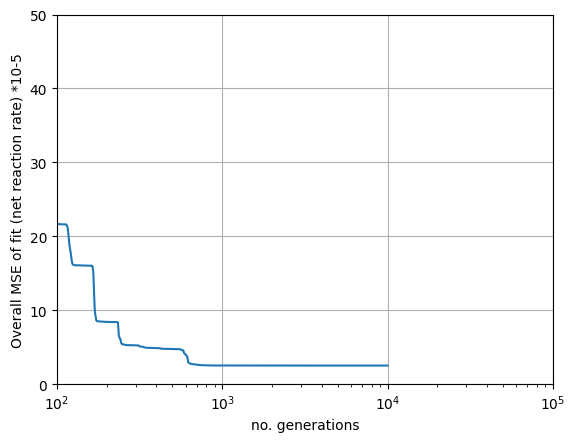

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

0.5831740180956129
8.083196949439612
8.082790330618275
1.049665605954527
8.219574859469123
8.234528696175264
8.297541544666808
0.8054436134503214
6.832402330684912
6.860900581732154
6.737013988049909
6.803903214362713
1.6997031685047042
7.628345991261498
7.567136430212848
7.8344642107710785
7.721951743546364
2.580003860983858
8.584868362754873
0.9429474176262671
7.954086480989406
7.956982934219106
7.9419517033326406
6.943059809655069
0.412748356029115
6.4165512941365295
3.0407405738843747
6.032781570657732
8.030878814605488
8.059973327256161
1.766628268321667
8.76780214707918
-1.30103
0.2832350591757277


In [34]:
res.X

array([ 0.58317402,  8.08319695,  8.08279033,  1.04966561,  8.21957486,
        8.2345287 ,  8.29754154,  0.80544361,  6.83240233,  6.86090058,
        6.73701399,  6.80390321,  1.69970317,  7.62834599,  7.56713643,
        7.83446421,  7.72195174,  2.58000386,  8.58486836,  0.94294742,
        7.95408648,  7.95698293,  7.9419517 ,  6.94305981,  0.41274836,
        6.41655129,  3.04074057,  6.03278157,  8.03087881,  8.05997333,
        1.76662827,  8.76780215, -1.30103   ,  0.28323506])

In [35]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3
    
import numpy as np
logkr=np.log10(kr)
logkr

array([1. , 8.5, 8.5, 2. , 9. , 9. , 9. , 2. , 8. , 8. , 8. , 8. , 2. ,
       8. , 8. , 8. , 8. , 2. , 8. , 1. , 8. , 8. , 8. , 7. , 1. , 7. ,
       3. , 6. , 8. , 8. , 1. , 8. , 0.1])

In [36]:
for i in range(len (logkr)):
    print (logkr[i])

1.0
8.5
8.5
2.0
9.0
9.0
9.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
1.0
8.0
8.0
8.0
7.0
1.0
7.0
3.0
6.0
8.0
8.0
1.0
8.0
0.10000000000000002


In [37]:
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-2]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

1.0: 0.5831740180956129
8.5: 8.083196949439612
8.5: 8.082790330618275
2.0: 1.049665605954527
9.0: 8.219574859469123
9.0: 8.234528696175264
9.0: 8.297541544666808
2.0: 0.8054436134503214
8.0: 6.832402330684912
8.0: 6.860900581732154
8.0: 6.737013988049909
8.0: 6.803903214362713
2.0: 1.6997031685047042
8.0: 7.628345991261498
8.0: 7.567136430212848
8.0: 7.8344642107710785
8.0: 7.721951743546364
2.0: 2.580003860983858
8.0: 8.584868362754873
1.0: 0.9429474176262671
8.0: 7.954086480989406
8.0: 7.956982934219106
8.0: 7.9419517033326406
7.0: 6.943059809655069
1.0: 0.412748356029115
7.0: 6.4165512941365295
3.0: 3.0407405738843747
6.0: 6.032781570657732
8.0: 8.030878814605488
8.0: 8.059973327256161
1.0: 1.766628268321667
8.0: 8.76780214707918
0.10000000000000002: 0.2832350591757277
coeff fit: 0.9568576809705178
r: 0.9781910247853013


In [ ]:
# Use stored solution
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3

import numpy as np
logkr=np.log10(kr)

logkr=np.ndarray.tolist(logkr)

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 =  np.ndarray.tolist(res.X)
krseed10 = 
krseed101 = 

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-2]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([0, 10])
plt.ylim([0, 10])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()